In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import glob
from datetime import datetime
from pytz import timezone
import pytz
import json
import calendar

# Lectura y Ajuste de datos

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
paths=sorted(glob.glob(r'/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Data_Hycom/*.nc'))
paths
#Guardamos los xrdatasets en una lista
data_list=[]
for e in paths:
    #print(e)
    try:
      data_list.append(xr.open_dataset(e))
    except:
      print('Falla:',e)

In [4]:
#Corregir las longitudes: Pasar aquellas en -180° a 360°
#identificar la posicion de los dataset en -180°
neg_lon=[]
for i in range(len(data_list)):
    if np.mean(data_list[i].lon.values)<0:
        neg_lon.append(i)
#Corregir a 360°
for n in neg_lon:
    data_list[n]=data_list[n].assign_coords(lon=(data_list[n].lon + 360))
    #print(data_list[n].longitude.values)

In [5]:
#Antes de agrupar se eliminan duplicados 
for e in range(len(data_list)):
  data_list[e]=data_list[e].drop_duplicates(dim='time')

In [6]:
#Ajustar las horas impares restandoles 3 horas

for e in range(len(data_list)):
  new_time=[]
  for i in data_list[e].time:
    if i.dt.hour.values%2==0:
      new_time.append(i.values)
    else: 
      new_time.append(i.values-np.timedelta64(3, 'h'))
  data_list[e]=data_list[e].assign_coords(time=new_time)

In [7]:
#Filtrar a las latitudes y longitudes deseadas para reducir el volumen de informacion
for e in range(len(data_list)):
  data_list[e]=data_list[e].sel(lat=[12.56,12.64],lon=[278.24,278.32],method='nearest')

In [8]:
#Se combinan los datos en un unico dataset
data_set=xr.merge(data_list)
data_set


/usr/local/lib/python3.10/dist-packages/xarray/coding/variables.py:142: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  condition |= data == fv


<xarray.Dataset>
Dimensions:     (time: 15899, lat: 2, lon: 2, depth: 20)
Coordinates:
  * time        (time) datetime64[ns] 2012-01-01T12:00:00 ... 2022-12-31T18:0...
  * lat         (lat) float32 12.56 12.64
  * lon         (lon) float32 278.2 278.3
  * depth       (depth) float32 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
Data variables:
    water_temp  (time, depth, lat, lon) float64 27.19 27.17 27.23 ... nan nan
    salinity    (time, depth, lat, lon) float64 35.97 35.91 36.0 ... nan nan nan

In [9]:
#Correccion de zona horaria ??????
#Zonas horarias
hycom_tz=pytz.timezone("GMT")
local_tz=pytz.timezone("America/Bogota")
new_time=[]
for i in range(len(data_set.time.data)):
    new_time.append(hycom_tz.localize(pd.to_datetime(data_set.time.data[i])).astimezone(local_tz).replace(tzinfo=None))
#new_time

# Promedio Trimestral

In [10]:
#Promedio trimestral multianual
ds_threemonthly = data_set.groupby("time.season").mean("time")
ds_threemonthly

<xarray.Dataset>
Dimensions:     (lat: 2, lon: 2, depth: 20, season: 4)
Coordinates:
  * lat         (lat) float32 12.56 12.64
  * lon         (lon) float32 278.2 278.3
  * depth       (depth) float32 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * season      (season) object 'DJF' 'JJA' 'MAM' 'SON'
Data variables:
    water_temp  (season, depth, lat, lon) float64 27.56 27.56 27.55 ... nan nan
    salinity    (season, depth, lat, lon) float64 35.96 35.96 35.96 ... nan nan

In [ ]:
# #Grafica de temperatura promedio trimestral
# PlotT=ds_threemonthly.water_temp.isel(lat=0,lon=1)
# #PlotT2=ds_threemonthly.water_temp.isel(latitude=1,longitude=1)
# #PlotT3=ds_threemonthly.water_temp.isel(latitude=1,longitude=2)
# #PlotT4=ds_threemonthly.water_temp.isel(latitude=3,longitude=0)
# #PlotT5=ds_threemonthly.water_temp.isel(latitude=3,longitude=1)
# #PlotT6=ds_threemonthly.water_temp.isel(latitude=3,longitude=2)
# fig, axs = plt.subplots(1,4,figsize=(8,6),sharey=True)

# axs[0].plot(PlotT[PlotT.season=='DJF'].values[0],-PlotT.depth, 
#             label='Lat:'+str(np.round(PlotT.lat.values,2))+' Lon:'+str(np.round(PlotT.lon.values,2))
#             , marker='o')
# #axs[0].plot(PlotT2[PlotT2.season=='DJF'].values[0],-PlotT2.depth)
# #axs[0].plot(PlotT3[PlotT3.season=='DJF'].values[0],-PlotT3.depth)
# #axs[0].plot(PlotT4[PlotT4.season=='DJF'].values[0],-PlotT4.depth)
# #axs[0].plot(PlotT5[PlotT5.season=='DJF'].values[0],-PlotT5.depth)
# #axs[0].plot(PlotT6[PlotT6.season=='DJF'].values[0],-PlotT6.depth)
# axs[0].set_title('DJF')
# axs[0].grid()
# #axs[0].legend()
# #axs[0].set_xlabel('Temperatura [°C]')

# axs[1].plot(PlotT[PlotT.season=='MAM'].values[0],-PlotT.depth, 
#             label='Lat:'+str(np.round(PlotT.lat.values,2))+' Lon:'+str(np.round(PlotT.lon.values,2))
#             , marker='o')
# #axs[1].plot(PlotT2[PlotT2.season=='MAM'].values[0],-PlotT2.depth)
# #axs[1].plot(PlotT3[PlotT3.season=='MAM'].values[0],-PlotT3.depth)
# #axs[1].plot(PlotT4[PlotT4.season=='MAM'].values[0],-PlotT4.depth)
# #axs[1].plot(PlotT5[PlotT5.season=='MAM'].values[0],-PlotT5.depth)
# #axs[1].plot(PlotT6[PlotT6.season=='MAM'].values[0],-PlotT6.depth)
# axs[1].set_title('MAM')
# axs[1].grid()
# #axs[1].legend()
# #axs[1].set_xlabel('Temperatura [°C]')

# axs[2].plot(PlotT[PlotT.season=='JJA'].values[0],-PlotT.depth, 
#             label='Lat:'+str(np.round(PlotT.lat.values,2))+' Lon:'+str(np.round(PlotT.lon.values,2))
#             , marker='o')
# #axs[2].plot(PlotT2[PlotT2.season=='JJA'].values[0],-PlotT2.depth)
# #axs[2].plot(PlotT3[PlotT3.season=='JJA'].values[0],-PlotT3.depth)
# #axs[2].plot(PlotT4[PlotT4.season=='JJA'].values[0],-PlotT4.depth)
# #axs[2].plot(PlotT5[PlotT5.season=='JJA'].values[0],-PlotT5.depth)
# #axs[2].plot(PlotT6[PlotT6.season=='JJA'].values[0],-PlotT6.depth)
# axs[2].set_title('JJA')
# axs[2].grid()
# #axs[2].legend()
# #axs[2].set_xlabel('Temperatura [°C]')

# axs[3].plot(PlotT[PlotT.season=='SON'].values[0],-PlotT.depth, 
#             label='Lat:'+str(np.round(PlotT.lat.values,2))+' Lon:'+str(np.round(PlotT.lon.values,2))
#             , marker='o')
# #axs[3].plot(PlotT2[PlotT2.season=='SON'].values[0],-PlotT2.depth)
# #axs[3].plot(PlotT3[PlotT3.season=='SON'].values[0],-PlotT3.depth)
# #axs[3].plot(PlotT4[PlotT4.season=='SON'].values[0],-PlotT4.depth)
# #axs[3].plot(PlotT5[PlotT5.season=='SON'].values[0],-PlotT5.depth)
# #axs[3].plot(PlotT6[PlotT6.season=='SON'].values[0],-PlotT6.depth, marker='o')
# axs[3].set_title('SON')
# axs[3].grid()
# axs[3].legend()
# #axs[3].set_xlabel('Temperatura [°C]')

# plt.ylim(bottom=-200,top=0)
# fig.suptitle('Temperatura Promedio Trimestral Multianual',fontsize=20,fontweight ="bold")
# fig.supylabel('Profundidad [m]')
# fig.supxlabel('Tempertura [°C]')

In [ ]:
# #Grafica de salinidad promedio trimestral
# PlotS=ds_threemonthly.salinity.isel(lat=0,lon=1)
# #PlotS2=ds_threemonthly.salinity.isel(latitude=1,longitude=1)
# #PlotS3=ds_threemonthly.salinity.isel(latitude=1,longitude=2)
# #PlotS4=ds_threemonthly.salinity.isel(latitude=3,longitude=0)
# #PlotS5=ds_threemonthly.salinity.isel(latitude=3,longitude=1)
# #PlotS6=ds_threemonthly.salinity.isel(latitude=3,longitude=2)
# fig, axs = plt.subplots(1,4,figsize=(8,6),sharey=True)

# axs[0].plot(PlotS[PlotS.season=='DJF'].values[0],-PlotS.depth, 
#             label='Lat:'+str(np.round(PlotT.lat.values,2))+' Lon:'+str(np.round(PlotT.lon.values,2))
#             , marker='o')
# #axs[0].plot(PlotS2[PlotS2.season=='DJF'].values[0],-PlotS2.depth)
# #axs[0].plot(PlotS3[PlotS3.season=='DJF'].values[0],-PlotS3.depth)
# #axs[0].plot(PlotS4[PlotS4.season=='DJF'].values[0],-PlotS4.depth)
# #axs[0].plot(PlotS5[PlotS5.season=='DJF'].values[0],-PlotS5.depth)
# #axs[0].plot(PlotS6[PlotS6.season=='DJF'].values[0],-PlotS6.depth)
# axs[0].set_title('DJF')
# axs[0].grid()
# #axs[0].legend()
# #axs[0].set_xlabel('Salinidad [PSU]')

# axs[1].plot(PlotS[PlotS.season=='MAM'].values[0],-PlotS.depth, 
#             label='Lat:'+str(np.round(PlotS.lat.values,2))+' Lon:'+str(np.round(PlotS.lon.values,2))
#             , marker='o')
# #axs[1].plot(PlotS2[PlotS2.season=='MAM'].values[0],-PlotS2.depth)
# #axs[1].plot(PlotS3[PlotS3.season=='MAM'].values[0],-PlotS3.depth)
# #axs[1].plot(PlotS4[PlotS4.season=='MAM'].values[0],-PlotS4.depth)
# #axs[1].plot(PlotS5[PlotS5.season=='MAM'].values[0],-PlotS5.depth)
# #axs[1].plot(PlotS6[PlotS6.season=='MAM'].values[0],-PlotS6.depth)
# axs[1].set_title('MAM')
# axs[1].grid()
# #axs[1].legend()
# #axs[1].set_xlabel('Salinidad [PSU]')

# axs[2].plot(PlotS[PlotS.season=='JJA'].values[0],-PlotS.depth, 
#             label='Lat:'+str(np.round(PlotS.lat.values,2))+' Lon:'+str(np.round(PlotS.lon.values,2))
#             , marker='o')
# #axs[2].plot(PlotS2[PlotS2.season=='JJA'].values[0],-PlotS2.depth)
# #axs[2].plot(PlotS3[PlotS3.season=='JJA'].values[0],-PlotS3.depth)
# #axs[2].plot(PlotS4[PlotS4.season=='JJA'].values[0],-PlotS4.depth)
# #axs[2].plot(PlotS5[PlotS5.season=='JJA'].values[0],-PlotS5.depth)
# #axs[2].plot(PlotS6[PlotS6.season=='JJA'].values[0],-PlotS6.depth)
# axs[2].set_title('JJA')
# axs[2].grid()
# #axs[2].legend()
# #axs[2].set_xlabel('Salinidad [PSU]')

# axs[3].plot(PlotS[PlotS.season=='SON'].values[0],-PlotS.depth, 
#             label='Lat:'+str(np.round(PlotS.lat.values,2))+' Lon:'+str(np.round(PlotS.lon.values,2))
#             , marker='o')
# #axs[3].plot(PlotS2[PlotS2.season=='SON'].values[0],-PlotS2.depth)
# #axs[3].plot(PlotS3[PlotS3.season=='SON'].values[0],-PlotS3.depth)
# #axs[3].plot(PlotS4[PlotS4.season=='SON'].values[0],-PlotS4.depth)
# #axs[3].plot(PlotS5[PlotS5.season=='SON'].values[0],-PlotS5.depth)
# #axs[3].plot(PlotS6[PlotS6.season=='SON'].values[0],-PlotS6.depth)
# axs[3].set_title('SON')
# axs[3].grid()
# axs[3].legend(loc='lower center')
# #axs[3].set_xlabel('Salinidad [PSU]')

# plt.ylim(bottom=-200,top=0)
# fig.suptitle('Salinidad Promedio Trimestral Multianual',fontsize=20,fontweight ="bold")
# fig.supxlabel('Salinidad [PSU]')
# fig.supylabel('Profundidad [m]')
# #fig.legend(loc='right')

Text(0.5, 0.98, 'Comparación trimestral - Lat:12.56 Lon:278.32')

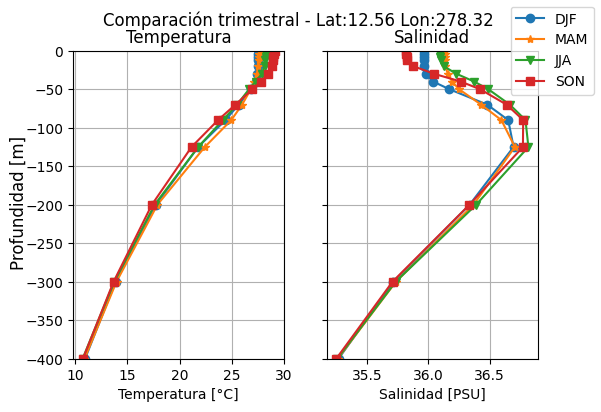

In [11]:
#Grafico comparativo entre trimestres
PlotT=ds_threemonthly.water_temp.isel(lat=0,lon=1).where(ds_threemonthly.depth<=400,drop=True)
PlotS=ds_threemonthly.salinity.isel(lat=0,lon=1).where(ds_threemonthly.depth<=400,drop=True)
fig, axs =plt.subplots(1,2,figsize=(6,4),sharey=True)
axs[0].plot(PlotT[PlotT.season=='DJF'].values[0],-PlotT.depth,label='DJF', marker='o')
axs[0].plot(PlotT[PlotT.season=='MAM'].values[0],-PlotT.depth,label='MAM', marker='*')
axs[0].plot(PlotT[PlotT.season=='JJA'].values[0],-PlotT.depth,label='JJA', marker='v')
axs[0].plot(PlotT[PlotT.season=='SON'].values[0],-PlotT.depth,label='SON', marker='s')
axs[0].set_title('Temperatura')
axs[0].grid()
axs[0].set_xlabel('Temperatura [°C]')

axs[1].plot(PlotS[PlotS.season=='DJF'].values[0],-PlotS.depth, marker='o')
axs[1].plot(PlotS[PlotS.season=='MAM'].values[0],-PlotS.depth, marker='*')
axs[1].plot(PlotS[PlotS.season=='JJA'].values[0],-PlotS.depth, marker='v')
axs[1].plot(PlotS[PlotS.season=='SON'].values[0],-PlotS.depth, marker='s')
axs[1].set_title('Salinidad')
axs[1].grid()
axs[1].set_xlabel('Salinidad [PSU]')

plt.ylim(bottom=-400,top=0)
fig.supylabel('Profundidad [m]')
fig.legend(loc='upper right')
fig.suptitle('Comparación trimestral'+' - Lat:'+str(np.round(PlotS.lat.values,2))+' Lon:'+str(np.round(PlotS.lon.values,2)))


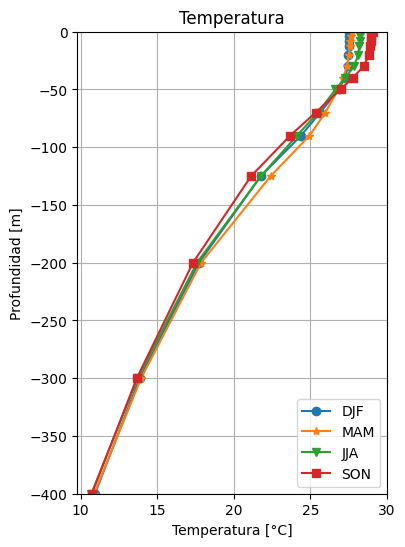

In [12]:
plt.figure(figsize=(4,6))
plt.plot(PlotT[PlotT.season=='DJF'].values[0],-PlotT.depth,label='DJF', marker='o')
plt.plot(PlotT[PlotT.season=='MAM'].values[0],-PlotT.depth,label='MAM', marker='*')
plt.plot(PlotT[PlotT.season=='JJA'].values[0],-PlotT.depth,label='JJA', marker='v')
plt.plot(PlotT[PlotT.season=='SON'].values[0],-PlotT.depth,label='SON', marker='s')
plt.title('Temperatura')
plt.grid()
plt.xlabel('Temperatura [°C]')
plt.ylim(bottom=-400,top=0)
plt.ylabel('Profundidad [m]')
plt.legend(loc='lower right')

#plt.suptitle('Comparación trimestral'+' - Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2)))

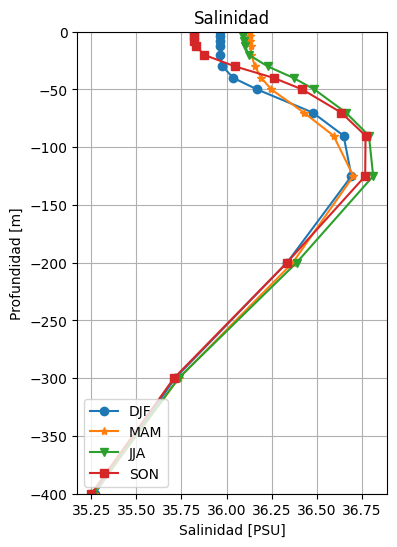

In [13]:
plt.figure(figsize=(4,6))
plt.plot(PlotS[PlotS.season=='DJF'].values[0],-PlotS.depth,label='DJF', marker='o')
plt.plot(PlotS[PlotS.season=='MAM'].values[0],-PlotS.depth,label='MAM', marker='*')
plt.plot(PlotS[PlotS.season=='JJA'].values[0],-PlotS.depth,label='JJA', marker='v')
plt.plot(PlotS[PlotS.season=='SON'].values[0],-PlotS.depth,label='SON', marker='s')
plt.title('Salinidad')
plt.grid()
plt.xlabel('Salinidad [PSU]')
plt.ylim(bottom=-400,top=0)
plt.ylabel('Profundidad [m]')
plt.legend(loc='lower left')

#plt.suptitle('Comparación trimestral'+' - Lat:'+str(np.round(PlotS.latitude.values,2))+' Lon:'+str(np.round(PlotS.longitude.values,2)))

DJF
MAM
JJA
SON


(Text(0.5, 0, 'Temporada'), Text(0, 0.5, 'Profundidad [m]'))

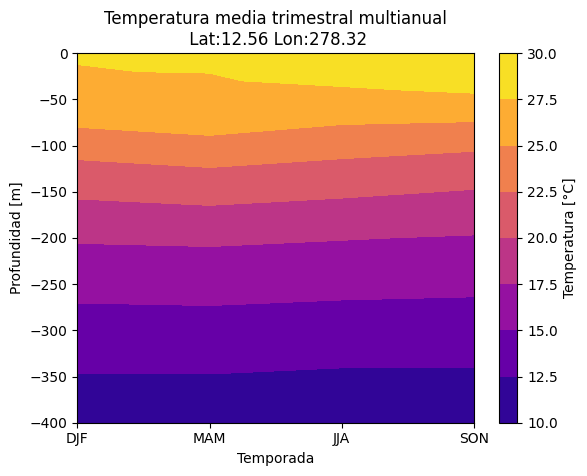

In [22]:
#Grafico en matriz de T trimestral
#Armar la matriz
mat_T_trim=[]
T_3monthly=ds_threemonthly.water_temp.isel(lat=0,lon=1).where(ds_threemonthly.depth<=400,drop=True)
for i in ['DJF','MAM','JJA','SON']:
  print(T_3monthly.sel(season=i).season.values)
  mat_T_trim.append(T_3monthly.sel(season=i).data)

#Coordenadas profundidad y mes
Depth=T_3monthly.depth.values
Temporada=['DJF','MAM','JJA','SON']
#Graficamos
plt.contourf(Temporada,-Depth,np.array(mat_T_trim).transpose(),cmap='plasma')
plt.colorbar(label='Temperatura [°C]')
plt.ylim(top=0,bottom=-400)
plt.title('Temperatura media trimestral multianual'+'\n Lat:'+str(np.round(T_3monthly.lat.data,2))+' Lon:'+str(np.round(T_3monthly.lon.data,2)))
plt.xlabel('Temporada'), plt.ylabel('Profundidad [m]')

DJF
MAM
JJA
SON


(Text(0.5, 0, 'Temporada'), Text(0, 0.5, 'Profundidad [m]'))

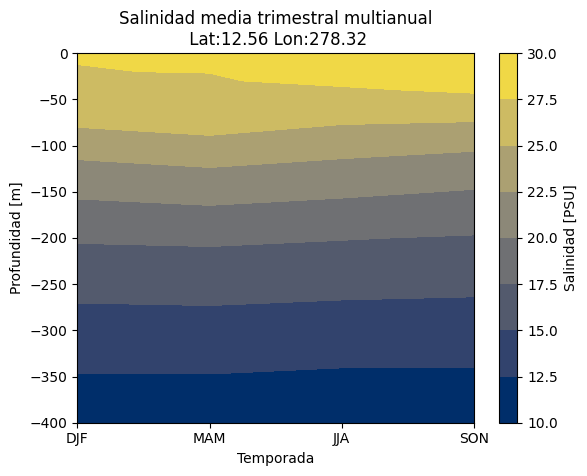

In [23]:
#Grafico en matriz de T trimestral
#Armar la matriz
mat_S_trim=[]
S_3monthly=ds_threemonthly.salinity.isel(lat=0,lon=1).where(ds_threemonthly.depth<=400,drop=True)
for i in ['DJF','MAM','JJA','SON']:
  print(S_3monthly.sel(season=i).season.values)
  mat_S_trim.append(T_3monthly.sel(season=i).data)

#Coordenadas profundidad y mes
Depth=S_3monthly.depth.values
Temporada=['DJF','MAM','JJA','SON']
#Graficamos
plt.contourf(Temporada,-Depth,np.array(mat_S_trim).transpose(),cmap='cividis')
plt.colorbar(label='Salinidad [PSU]')
plt.ylim(top=0,bottom=-400)
plt.title('Salinidad media trimestral multianual'+'\n Lat:'+str(np.round(S_3monthly.lat.data,2))+' Lon:'+str(np.round(S_3monthly.lon.data,2)))
plt.xlabel('Temporada'), plt.ylabel('Profundidad [m]')

# Promedio Mensual Multianual

In [24]:
#Promedio mensual multianual
ds_monthly = data_set.groupby("time.month").mean("time")
ds_monthly

<xarray.Dataset>
Dimensions:     (lat: 2, lon: 2, depth: 20, month: 12)
Coordinates:
  * lat         (lat) float32 12.56 12.64
  * lon         (lon) float32 278.2 278.3
  * depth       (depth) float32 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * month       (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    water_temp  (month, depth, lat, lon) float64 27.4 27.4 27.39 ... nan nan nan
    salinity    (month, depth, lat, lon) float64 36.0 36.0 35.99 ... nan nan nan

In [ ]:
#Grafica comparativa de promedios mensuales multianuales
# fig, axs = plt.subplots(1,2,figsize=(9,6),sharey=True)

# for a in range(0,2):
#     #print(a)
#     if a==0:
#         for b in range(1,13):
#             axs[a].plot(ds_monthly.water_temp.isel(lat=0,lon=1)[ds_monthly.water_temp.month==b].values[0]
#                       ,-ds_monthly.depth,label=str(nombre_meses[b-1]))
#         axs[a].grid()
#         axs[a].set_title('Temperatura')
#         axs[a].set_xlabel('Temperatura [°C]')
#     else:
#         for b in range(1,13):
#             axs[a].plot(ds_monthly.salinity.isel(lat=0,lon=1)[ds_monthly.water_temp.month==b].values[0]
#                       ,-ds_monthly.depth)
#         axs[a].grid()
#         axs[a].set_title('Salinidad')
#         axs[a].set_xlabel('Salinidad [PSU]')
# plt.ylim(bottom=-200,top=0)
# fig.legend(loc='right')
# fig.suptitle('Comparacion promedio mensual multianual'+
#              '\n Lat:'+str(np.round(PlotS.lat.values,2))+
#              ' Lon:'+str(np.round(PlotS.lon.values,2)))
# fig.supylabel('Profundidad [m]')

#Paleta de jet

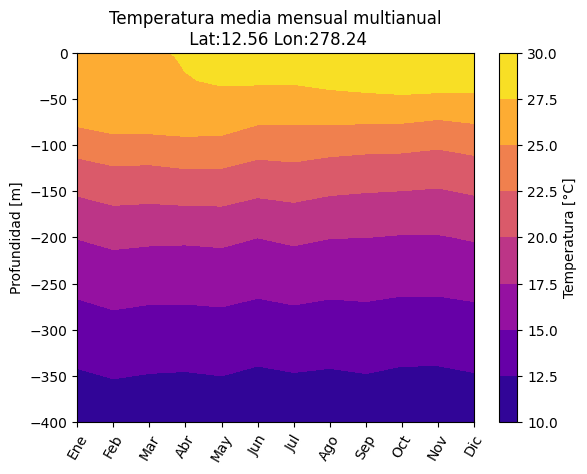

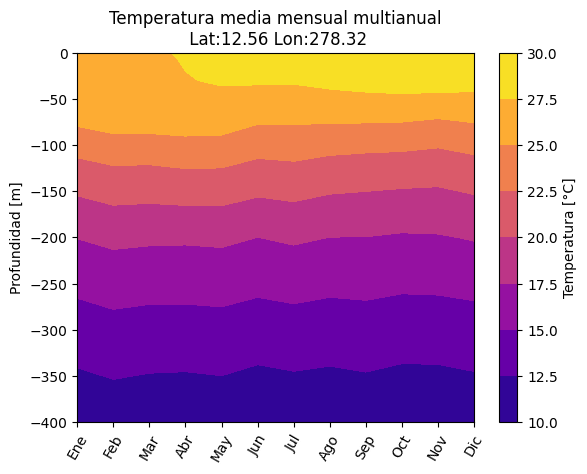

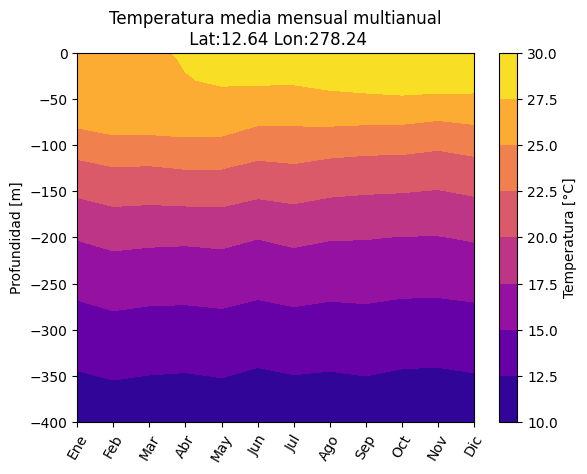

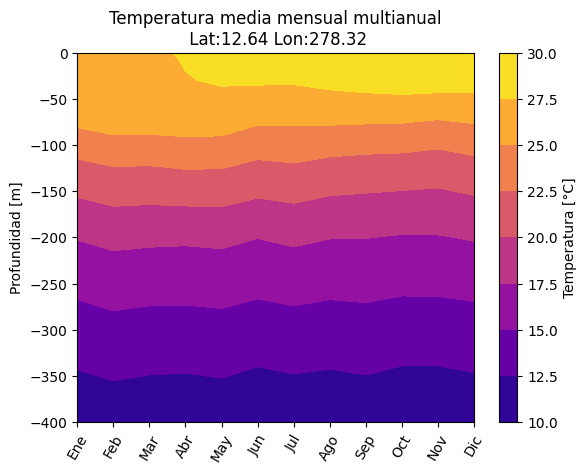

In [26]:
#Grafico en matriz de T
Matrices=[]
Puntos=[]
for ilat in ds_monthly.lat.values:
  for ilon in ds_monthly.lon.values:
    #Armar la matriz
    Matriz=[]
    Puntos.append([ilat,ilon])
    Tmonthly=ds_monthly.water_temp.sel(lat=ilat,lon=ilon,method='nearest').where(ds_monthly.depth<=400,drop=True)
    for i in range(1,13):
      Matriz.append(Tmonthly.isel(month=i-1).data)
    Matrices.append(Matriz)
#Coordenadas profundidad y mes
Depth=ds_monthly.where(ds_monthly.depth<=400,drop=True).depth.values
Meses=ds_monthly.month.values

#Graficamos
#monthsname=calendar.month_abbr[1:]
mesesDicAbr = {
    "01":'Ene',
    "02":'Feb',
    "03":'Mar',
    "04":'Abr',
    "05":'May',
    "06":'Jun',
    "07":'Jul',
    "08":'Ago',
    "09":'Sep',
    "10":'Oct',
    "11":'Nov',
    "12":'Dic'
}
for m in range(len(Matrices)):
  plt.contourf(mesesDicAbr.values(),-Depth,np.array(Matrices[m]).transpose(),cmap='plasma')
  plt.colorbar(label='Temperatura [°C]')
  plt.ylim(top=0,bottom=-400)
  plt.title('Temperatura media mensual multianual'+'\n Lat:'+str(np.round(Puntos[m][0],2))+' Lon:'+str(np.round(Puntos[m][1],2)))
  #plt.xlabel('Tiempo [Mes]'), 
  plt.ylabel('Profundidad [m]')
  plt.tick_params(axis='x', rotation=60)
  plt.show()

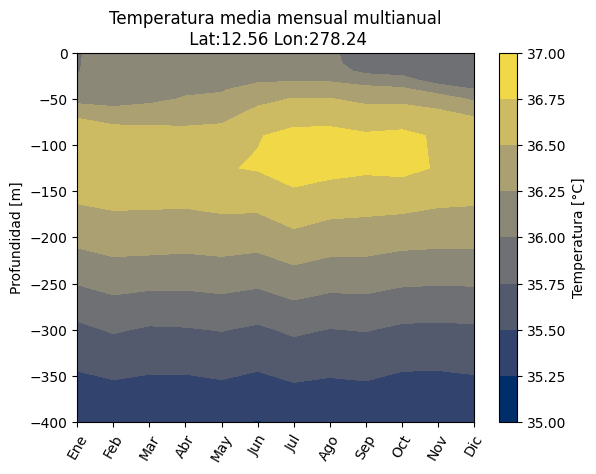

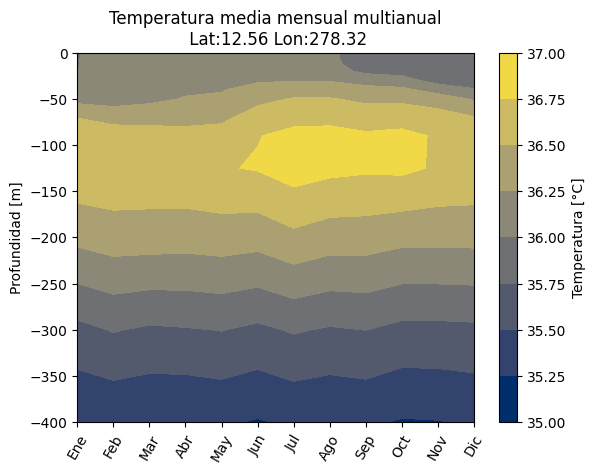

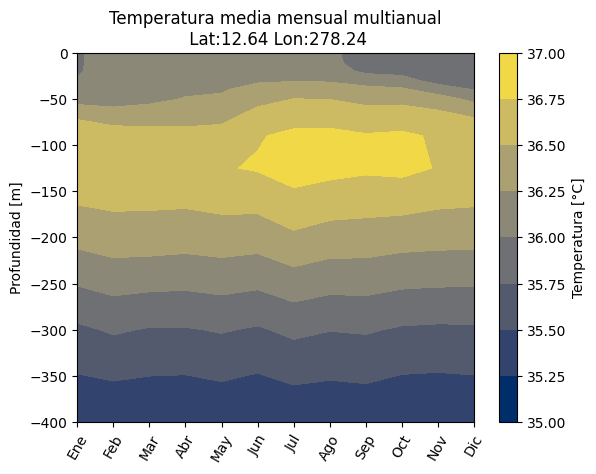

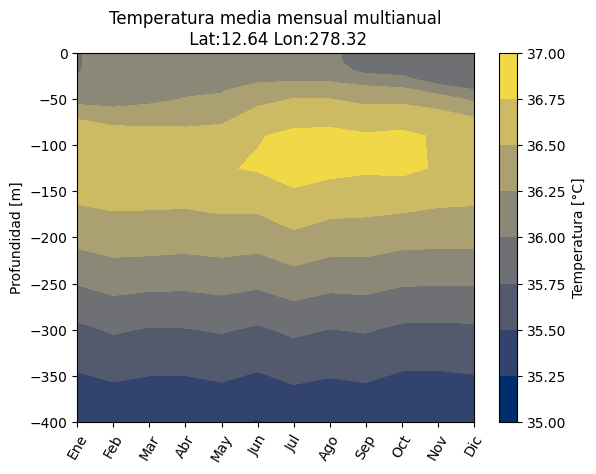

In [27]:
#Grafico en matriz de S
Matrices=[]
Puntos=[]
for ilat in ds_monthly.lat.values:
  for ilon in ds_monthly.lon.values:
    #Armar la matriz
    Matriz=[]
    Puntos.append([ilat,ilon])
    Smonthly=ds_monthly.salinity.sel(lat=ilat,lon=ilon,method='nearest').where(ds_monthly.depth<=400,drop=True)
    for i in range(1,13):
      Matriz.append(Smonthly.isel(month=i-1).data)
    Matrices.append(Matriz)
#Coordenadas profundidad y mes
Depth=ds_monthly.where(ds_monthly.depth<=400,drop=True).depth.values
Meses=ds_monthly.month.values

#Graficamos
#monthsname=calendar.month_abbr[1:]

for m in range(len(Matrices)):
  plt.contourf(mesesDicAbr.values(),-Depth,np.array(Matrices[m]).transpose(),cmap='cividis')
  plt.colorbar(label='Temperatura [°C]')
  plt.ylim(top=0,bottom=-400)
  plt.title('Temperatura media mensual multianual'+'\n Lat:'+str(np.round(Puntos[m][0],2))+' Lon:'+str(np.round(Puntos[m][1],2)))
  #plt.xlabel('Tiempo [Mes]'), 
  plt.ylabel('Profundidad [m]')
  plt.tick_params(axis='x', rotation=60)
  plt.show()

Archivos.json

In [ ]:
# monthsname=calendar.month_name[1:]
# dic_mean_month={}
# for ilon in ds_monthly.lon.values:
#   for ilat in ds_monthly.lat.values:
#     #print(ilon,ilat)
#     dic_month={}
#     for imonth in ds_monthly.month.values:
#       perfil=[]
#       for i in ds_monthly.salinity.where((ds_monthly.lon==278.32)&(ds_monthly.lat==12.56)&(ds_monthly.month==5),drop=True).values[0]:
#         perfil.append(i[0][0])
#       dic_month.update({monthsname[imonth-1]:perfil})
#     dic_mean_month.update({str(ilon)+'_'+str(ilat):dic_month})

# #namefile='/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Scripts/Mean_Montlhy_Sprofiles.json' #modificar la leta T o S segun la variable
# #with open(namefile, "w") as namefile:
# #    json.dump(dic_mean_month, namefile)

# Promedio ENSO

In [28]:
#Cargar datos del indice del ONI
ONI=pd.read_excel('/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Data_Hycom/ONI_NOAA.xlsx')
ONI
#Limite de +-0.5°C para condiciones de Niño y Niña
#Creamos la lista de condiciones de enso para cada fecha del dataset
enso_mode=[]
for i in range(len(data_set.time.values)):
    año=data_set.time.dt.year.values[i]
    mes=data_set.time.dt.month.values[i]
    if ONI[ONI['Year']==año][ONI.columns[mes]].values[0]<=-0.5:
        enso_mode.append('Niña')
    elif ONI[ONI['Year']==año][ONI.columns[mes]].values[0]>=0.5:
        enso_mode.append('Niño')
    else:
        enso_mode.append('Normal')


In [29]:
#Se establece como nueva coordenada los modos del enso.
data_set_enso=data_set.assign_coords(ENSO=('time',enso_mode))
data_set_enso

<xarray.Dataset>
Dimensions:     (time: 15899, lat: 2, lon: 2, depth: 20)
Coordinates:
  * time        (time) datetime64[ns] 2012-01-01T12:00:00 ... 2022-12-31T18:0...
  * lat         (lat) float32 12.56 12.64
  * lon         (lon) float32 278.2 278.3
  * depth       (depth) float32 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
    ENSO        (time) <U6 'Niña' 'Niña' 'Niña' 'Niña' ... 'Niña' 'Niña' 'Niña'
Data variables:
    water_temp  (time, depth, lat, lon) float64 27.19 27.17 27.23 ... nan nan
    salinity    (time, depth, lat, lon) float64 35.97 35.91 36.0 ... nan nan nan

In [30]:
#Se establece la media para cada modo del enso
ds_enso = data_set_enso.groupby("ENSO").mean()
ds_enso_std = data_set_enso.groupby("ENSO").std()
ds_enso

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: Run

<xarray.Dataset>
Dimensions:     (lat: 2, lon: 2, depth: 20, ENSO: 3)
Coordinates:
  * lat         (lat) float32 12.56 12.64
  * lon         (lon) float32 278.2 278.3
  * depth       (depth) float32 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * ENSO        (ENSO) object 'Niña' 'Niño' 'Normal'
Data variables:
    water_temp  (ENSO, depth, lat, lon) float64 28.16 28.16 28.16 ... nan nan
    salinity    (ENSO, depth, lat, lon) float64 35.95 35.95 35.95 ... nan nan

Text(0.02, 0.5, 'Profundidad [m]')

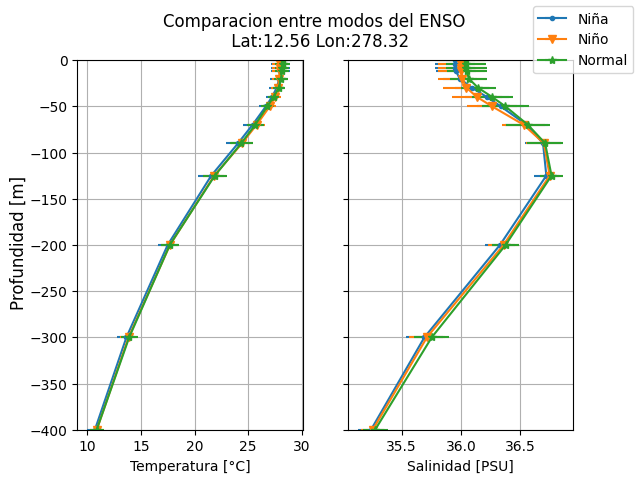

In [35]:
#Gráfica comparativa de entre cada modo del ENSO
fig, axs = plt.subplots(1,2,sharey=True)
markers=['.','v','*']
data_enso=ds_enso.isel(lat=0,lon=1).where(ds_enso.depth<=400,drop=True)
data_enso_std=ds_enso_std.isel(lat=0,lon=1).where(ds_enso.depth<=400,drop=True)
for i in range(0,2):
    if i==0:
        for e in range(0,3):
            axs[i].errorbar(data_enso.water_temp
                        [data_enso.water_temp.ENSO==data_enso.water_temp.ENSO[e]].values[0],
                       -data_enso.depth,
                       xerr=data_enso_std.water_temp[data_enso.water_temp.ENSO==data_enso.water_temp.ENSO[e]].values[0],
                        label=str(data_enso.ENSO[e].values),
                        marker=markers[e])
        #axs[i].set_title('Temperatura')
        axs[i].set_xlabel('Temperatura [°C]')
        axs[i].grid()
    elif i==1:
        for e in range(0,3):
            axs[i].errorbar(data_enso.salinity
                        [data_enso.salinity.ENSO==data_enso.salinity.ENSO[e]].values[0],
                       -data_enso.depth,
                       xerr=data_enso_std.salinity
                        [data_enso.salinity.ENSO==data_enso.salinity.ENSO[e]].values[0],
                        marker=markers[e])
        #axs[i].set_title('Salinidad')
        axs[i].set_xlabel('Salinidad [PSU]')
        axs[i].grid()

plt.ylim(bottom=-400,top=0)
fig.legend(loc='upper right')
fig.suptitle('Comparacion entre modos del ENSO'+
             ' \n Lat:'+str(np.round(data_enso.lat.values,2))+
             ' Lon:'+str(np.round(data_enso.lon.values,2)))
fig.supylabel('Profundidad [m]')

# Serie de Tiempo de T y S

In [ ]:
serie_Tsup=data_set.water_temp.isel(lat=0,lon=1,depth=0)
serie_Ssup=data_set.salinity.isel(lat=0,lon=1,depth=0)

serie_T20=data_set.water_temp.isel(lat=0,lon=1,depth=4)
serie_S20=data_set.salinity.isel(lat=0,lon=1,depth=4)

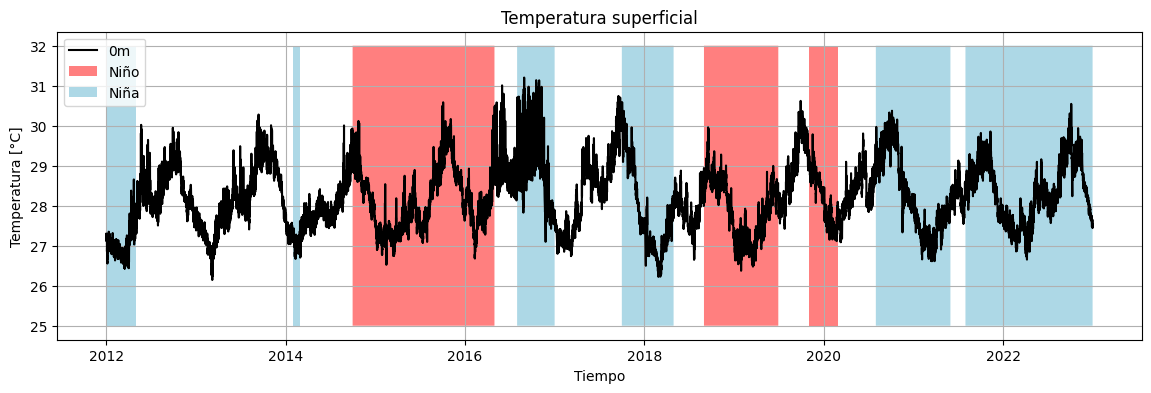

In [ ]:
#Grafica serie de temperatura superficial
plt.figure(figsize=(14,4))
plt.plot(serie_Tsup.time, serie_Tsup.values, label='0m', color='black')
#plt.plot(serie_T20.time, serie_T20.values, label='20m', color='yellow')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura [°C]')
plt.title('Temperatura superficial')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

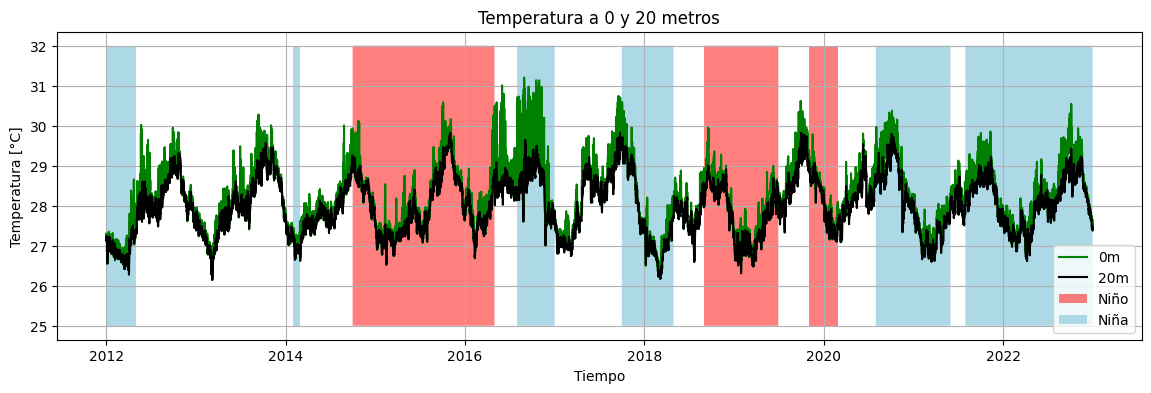

In [ ]:
#Grafica serie de temperatura a 20m
plt.figure(figsize=(14,4))
plt.plot(serie_Tsup.time, serie_Tsup.values, label='0m', color='green')
plt.plot(serie_T20.time, serie_T20.values, label='20m', color='black')
plt.xlabel('Tiempo')
plt.ylabel('Temperatura [°C]')
plt.title('Temperatura a 0 y 20 metros')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,25,32, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

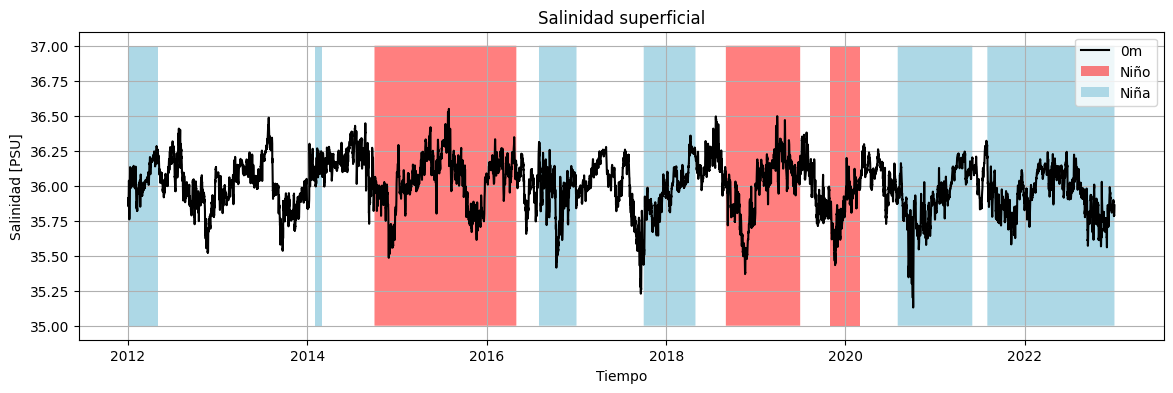

In [ ]:
#Grafica serie de salinidad superficial
plt.figure(figsize=(14,4))
plt.plot(serie_Ssup.time, serie_Ssup.values, label='0m', color='black')
#plt.plot(serie_S20.time, serie_S20.values, label='20m')
plt.xlabel('Tiempo')
plt.ylabel('Salinidad [PSU]')
plt.title('Salinidad superficial')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

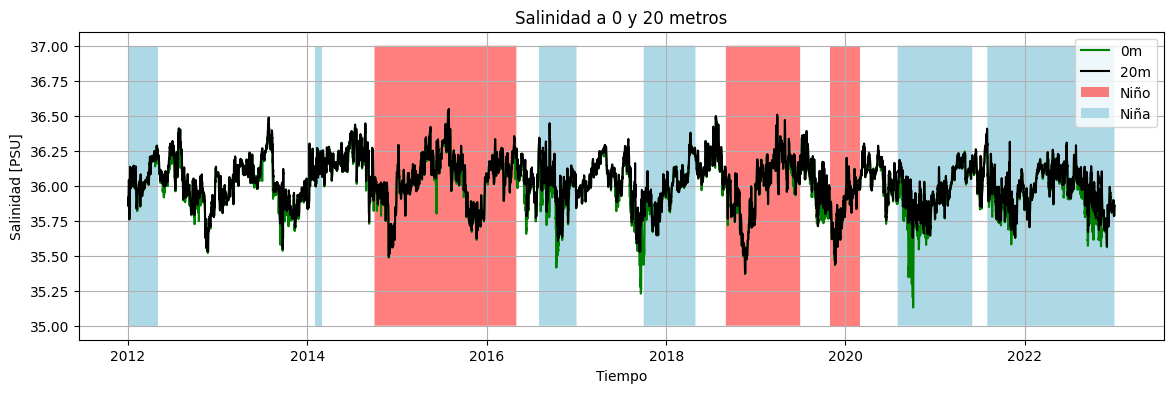

In [ ]:
#Grafica serie de salinidad a 20m
plt.figure(figsize=(14,4))
plt.plot(serie_Ssup.time, serie_Ssup.values, label='0m', color='green')
plt.plot(serie_S20.time, serie_S20.values, label='20m', color='black')
plt.xlabel('Tiempo')
plt.ylabel('Salinidad [PSU]')
plt.title('Salinidad a 0 y 20 metros')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niño',facecolor='red', alpha=.5 ,label='Niño')
plt.fill_between(data_set_enso.time,35,37, where=data_set_enso.ENSO=='Niña',facecolor='lightblue', alpha=1 ,label='Niña')
plt.legend()
plt.grid()

# Promedio de regimen de lluvias seco y humedo

In [36]:
#Crear una coordenada que identifique las epoca
epoca=[]

for i in range(len(data_set.time.values)):
  if data_set.time.dt.month.values[i] >=1 and data_set.time.dt.month.values[i] <=4:
    epoca.append('Seco')
  else:
    epoca.append('Humedo')

In [37]:
#Se añade la nueva coordenada
ds_regimen=data_set.assign_coords(regimen=('time',epoca))
ds_regimen
#Se promedia segun el regimen
ds_regimen_std=ds_regimen.groupby("regimen").std()
ds_regimen=ds_regimen.groupby("regimen").mean()

ds_regimen

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<xarray.Dataset>
Dimensions:     (lat: 2, lon: 2, depth: 20, regimen: 2)
Coordinates:
  * lat         (lat) float32 12.56 12.64
  * lon         (lon) float32 278.2 278.3
  * depth       (depth) float32 0.0 4.0 8.0 12.0 ... 1e+03 1.5e+03 2.5e+03 4e+03
  * regimen     (regimen) object 'Humedo' 'Seco'
Data variables:
    water_temp  (regimen, depth, lat, lon) float64 28.58 28.58 28.58 ... nan nan
    salinity    (regimen, depth, lat, lon) float64 35.97 35.97 35.97 ... nan nan

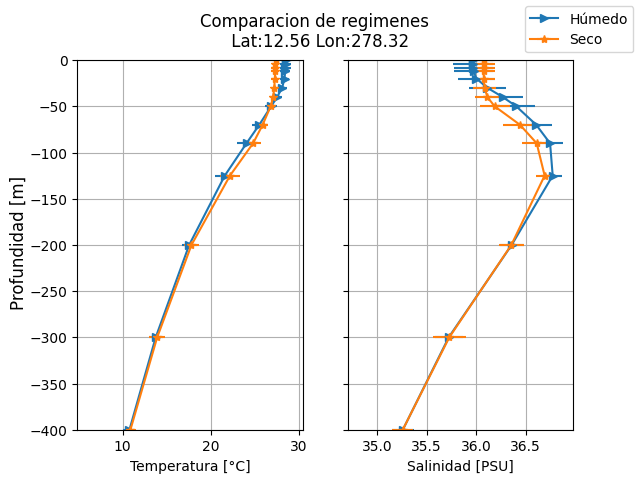

In [38]:
#Grafico comparativo

fig, axs = plt.subplots(1,2,sharey=True)

axs[0].errorbar(ds_regimen.water_temp.isel(lat=0,lon=1,regimen=0).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.water_temp.isel(lat=0,lon=1,regimen=0).values
            , label='Húmedo', fmt='->')
axs[0].errorbar(ds_regimen.water_temp.isel(lat=0,lon=0,regimen=1).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.water_temp.isel(lat=0,lon=1,regimen=1).values
            , label='Seco', fmt='-*')
axs[0].grid()
axs[0].set_xlabel('Temperatura [°C]')

axs[1].errorbar(ds_regimen.salinity.isel(lat=0,lon=1,regimen=0).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.salinity.isel(lat=0,lon=1,regimen=0).values
            , fmt='->')
axs[1].errorbar(ds_regimen.salinity.isel(lat=0,lon=0,regimen=1).values,-ds_regimen.depth.values, 
                xerr=ds_regimen_std.salinity.isel(lat=0,lon=1,regimen=1).values
            , fmt='-*')
axs[1].grid()
axs[1].set_xlabel('Salinidad [PSU]')

plt.ylim(top=0, bottom=-400)
fig.suptitle('Comparacion de regimenes'+
             ' \n Lat:'+str(np.round(ds_regimen.lat.values[0],2))+
             ' Lon:'+str(np.round(ds_regimen.lon.values[1],2)))
fig.supylabel('Profundidad [m]')
fig.legend()

# Comparación con AWAC 600

In [ ]:
#Leer los datos
path_AW=glob.glob(r'/content/drive/MyDrive/MODELO_NUMERICO/DATOS_CAMPO/DATOS_SAI_4_15_nov_2021/AWAC600/*.sen')
path_AW
def temperature_surface(path:str):
        func_date = lambda x: datetime.strptime(x, "%Y %m %d %H %M")
        df_press = pd.read_csv(f'{path}',delimiter='\s+', usecols=[0,1,2,3,4,14], 
                               names=["Month","Day","Year","Hour",'Minute','Temp'], 
                                parse_dates={'Time':['Year','Month', 'Day', 'Hour', 'Minute']}, 
                                date_parser=func_date).set_index('Time')
        #df_press = df_press[ini_date:end_date]
        #df_press['Temp'] = df_press['Temp'] - df_press['Temp'].mean()
        return df_press[['Temp']]
Temp_AW=temperature_surface(path_AW[0])

In [ ]:
Temp_AW['2021-11-06 11:00:00':'2021-11-14 05:00:00']

,Temp
Time,
2021-11-06 11:17:00,29.72
2021-11-06 11:47:00,29.58
2021-11-06 12:17:00,29.59
2021-11-06 12:47:00,29.57
2021-11-06 13:17:00,29.56
...,...
2021-11-14 02:47:00,29.33
2021-11-14 03:17:00,29.33
2021-11-14 03:47:00,29.32


(28.0, 30.0)

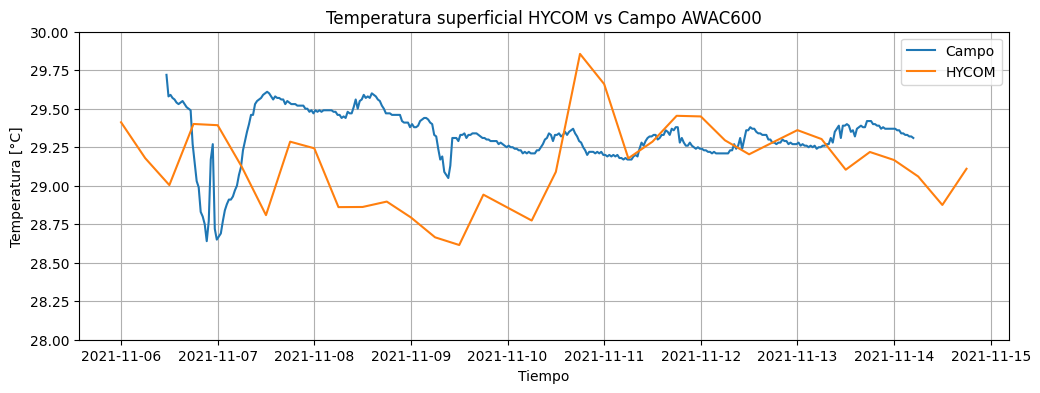

In [ ]:
#Separar los datos de HYCOM
# 6 a las 11am  hasta el 14 a 5am
Temp_sup_HYCOM=data_set.water_temp.isel(lat=0,lon=1,depth=0).sel(time=slice('2021-11-6','2021-11-14'))
plt.figure(figsize=(12,4))
plt.plot(Temp_AW['2021-11-06 11:00:00':'2021-11-14 05:00:00'],label='Campo')
plt.plot(Temp_sup_HYCOM.time,Temp_sup_HYCOM,label='HYCOM')
plt.grid(), plt.legend()
plt.title('Temperatura superficial HYCOM vs Campo AWAC600')
plt.xlabel('Tiempo'), plt.ylabel('Temperatura [°C]')
plt.ylim(bottom=28,top=30)

# Ubicación en batimetria

In [ ]:
!pip install mat73
!pip install pyproj
!pip install svgpathtools
!pip install svgpath2mpl
!pip install netCDF4
!pip install cartopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 57.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.4/67.4 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 kB 7.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 68.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 65.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━

In [ ]:
#mas librerias
import matplotlib as mpl
import os
from matplotlib import cm
import matplotlib.dates as mdates
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
import mat73
from pyproj import Proj
import matplotlib.pylab as pl
from scipy import signal
from os.path import dirname, join as pjoin
import scipy.io as sio
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
from netCDF4 import Dataset, num2date
import missingno as msno
import re 
import mat73
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cf
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [ ]:
#funciones
def fig_params(ax):
    ax.grid()    
    ax.spines['left'].set_color('gray')
    ax.spines['right'].set_color('gray')
    ax.spines['bottom'].set_color('gray')
    ax.spines['top'].set_color('gray')
    ax.tick_params('y', colors='tab:gray')
    ax.tick_params('x', colors='tab:gray')
    for label in ax.get_yticklabels():
        label.set_color('k')
        label.set_size(13)
    for label in ax.get_xticklabels():
        label.set_color('k')
        label.set_size(13)

def proj_ZONE17 (lon, lat):
    """
    Función para cambiar las proyecciones de las coordenadas:
    -----------------------------------------------------------
    Input:
    lon, lat
    ----------------------------------------------------------
    Output:
    UTMX, UTMY
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    UTMx, UTMy = myProj(lon, lat)
    return UTMx,UTMy

def coord_wgs (UTMx,UTMy):
    """
    Función para cambiar georeferenciar las proyecciones:
    ----------------------------------------------------------
    Input:
    UTMX, UTMY
    ----------------------------------------------------------
    Output:
    lon, lat
    """
    myProj = Proj("+proj=utm +zone=17 +ellps=WGS84 +datum=WGS84")
    lon, lat = myProj(UTMx,UTMy, inverse = True)
    return 360 + lon, lat

def read_grid_file_d3d(num_btw_lines:int, ncols:int, nrows:int, path:str, name_file_grid:str, name_file_deep:str):
    """
    This function read the data from .grd file obtened of d3d
    --------------------------------------------------------------------
    Input:
    - num_btw_lines: cantidad de lineas entre cada eta
    - nrows: numéro de filas del archivo
    - ncols: numéro de columnas del archivo
    - path: ruta del archivo
    - name_file_grid:nombre del archivo
    --------------------------------------------------------------------
    Output: 
    - dic_ : diccionario donde cada llave es una fila y contine 
    las respectivas coordendas que deben ser iguales al numero de columnas 
    """
    patron_eta = r'\b\w+=\s*\d+'
    patron_num =  r'\d+\.\d+E[+-]?\d+'

    with open(f'{path}/{name_file_grid}', 'r') as f:
        contenido = f.read ()
    keys_dic = re.findall(patron_eta, contenido)

    with open(f'{path}/{name_file_grid}', 'r') as f:
        lineas = f.readlines()

    dic_ = {}
    for j, key in enumerate (keys_dic):
        list_ = []
        for i, linea in enumerate(lineas):
            eta = re.findall(patron_eta, linea)
            try:
                if  key == eta[0]:
                    nums_linea = re.findall(patron_num, linea)
                    for nu in nums_linea:
                        list_.append(float(nu))
                    for k in range (1, num_btw_lines):
                        nums_linea_plus = re.findall(patron_num, lineas[i+k])
                        for num in nums_linea_plus:
                            list_.append(float(num))             
            except: 
                pass
        arr= np.array(list_).reshape((ncols-1, 2), order = 'F') 
        dic_.update({key:pd.DataFrame({'X': arr[:,0], 'Y': arr[:,1]})})
    
    patron_num =  r'[-+]?\d+\.\d+E[+-]?\d+'
    with open(f'{path}/{name_file_deep}', 'r') as f:
        contenido = f.read ()
    deep = re.findall(patron_num, contenido)
    Z = []
    for z in deep:
        Z.append(float(z))
    Z = np.array(Z).reshape((nrows, ncols))
    Z[Z<0] = np.nan
    # Z = Z[:-1, :-1]


    X = np.zeros(shape = (nrows-1, ncols-1))
    Y = np.zeros(shape = (nrows-1, ncols-1))
    for i, key in enumerate(list(dic_.keys())):
        X[i, :] = dic_[key]['X']
        Y[i, :] = dic_[key]['Y']

    return X,Y, Z

def read_coast_line (path:str, name_file:str):
    """
    Esta función lee los datos de la linea de costa de un archivo .mat (v6)
    -------------------------------------------------------------------------
    Input:
    - path: ruta del archivo
    - name_file: nombre del archivo
    -------------------------------------------------------------------------
    Output:
    - Data Frame de la linea dosta
    """
    data_dir = pjoin(dirname(sio.__file__), path) # Definir Ruta
    mat_fname = pjoin(data_dir, name_file)     # Econtrar el archivo
    data_mat = sio.loadmat(mat_fname)                 # Cargar el archivo
    xlc, ylc = np.array(data_mat['data'][0][0][0]), np.array(data_mat['data'][0][0][1])
    lc  = np.column_stack((xlc,ylc))
    df_lc = pd.DataFrame({'X':lc[:,0], 'Y':lc[:,1] })
    return df_lc

def bat_figure(df_lc:pd.DataFrame, X:np.array, Y:np.array, Z:np.array,delta_lim:float ,delta:float, active_puntos_obs: bool,size:tuple = (7, 5.5), df_ind = None, bottom_legend = None):
    """Función para graficar la malla orientada
    -------------------------------------------------------------------------------------------------
    Input: 
    - df_lc: linea de costa
    - X: arreglo en dos o una dimensión de la malla (dirección x)
    - Y: arreglo en dos o una dimensión de la malla (dirección y)
    - Z: arreglo de las profundidades, las dimesiones deben corresponder con las dimensiones de X y Y
    - size: tupla de las dimensiones de la figura
    - delta: delta para ubicar el norte respecto a la esquina superior derecha (se resta)
    - delta_lim: limites de la figura
    -------------------------------------------------------------------------------------------------
    Output:
    - Figure 

    """

    fig, ax = plt.subplots(figsize = size)
    colormap = cm.Blues
    levels = list(np.round(np.nanmax(Z)*np.array([0,1, 5, 10, 15, 20, 25, 50, 75, 100])/100,0))
    pc = ax.contourf(X, Y, Z,levels = levels,cmap=colormap)
    cb=plt.colorbar(pc)
    a = ax.contour(X, Y, Z,colors="gray",levels=levels,\
                    linewidths=0.2)
    labels = plt.clabel(a, fontsize=8, inline=1, fmt = '%1.0f', colors="gray")
    ax.set_xlabel ('E [m]',size=13, fontweight = 'semibold')
    ax.set_ylabel ('N [m]',size=13, fontweight = 'semibold')
    if (X.min() < df_lc['X'].min()) | (Y.min() < df_lc['Y'].min()):
            ax.set_xlim([X.min() - delta_lim, X.max() + delta_lim])
            ax.set_ylim([Y.min()- delta_lim, Y.max() + delta_lim])
    else:
        ax.set_xlim([df_lc['X'].min(), X.max() + delta_lim])
        ax.set_ylim([df_lc['Y'].min(), Y.max() - delta_lim])
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
    cb.set_label('Depth [m]',size=13, fontweight = 'semibold')
    cb.set_ticklabels(cb.get_ticks(),size=10)
    fig_params(ax)
    fig.suptitle("Bathymetry", size = 13, fontweight = 'semibold')     # Titulo de la figura
    ax.set_title('San Andrés Island',size = 13, fontweight = 'semibold')   # Subtítulo de la figura
    ax.plot(df_lc['X'], df_lc['Y'], "-",c='chocolate', lw=2.5, alpha = 1)
    ax.fill_between(df_lc['X'], df_lc['Y'], color='chocolate', alpha=0.5, linewidth=0)

    try:
      brujula_path, attributes = svg2paths('/content/drive/MyDrive/MODELO_NUMERICO/BASES_DE_DATOS/CLIMATOLOGIA_HYCOM/Scripts/brujula.svg')
    except: 
      brujula_path, attributes = svg2paths('brujula.svg')
    brujula_marker = parse_path(attributes[0]['d'])
    brujula_marker.vertices -= brujula_marker.vertices.mean(axis=0)
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().rotate_deg(0))
    brujula_marker = brujula_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    ax.scatter(X.max()-delta, Y.max()-delta, marker= brujula_marker, color = 'k', s = 8**3)

    if active_puntos_obs == True:
        colors = mpl.cm.jet_r(np.linspace(0,1,len(df_ind)))
        k = 0
        for col, row in zip (df_ind['Ind_X'], df_ind['Ind_Y']):
            ax.scatter(X[row, col], Y[row, col], marker = '+', color = colors[k], label = df_ind['ID'][k], s = 8**2, lw = 2)
            k = k+1
        _= ax.legend(loc='upper center', bbox_to_anchor=(0.5, bottom_legend),
                fancybox=True, shadow=True, ncol=4, fontsize = 9)


    fig.tight_layout()
    plt.xticks(rotation = 20)
    plt.grid(False)



def df_project_grid_grid(n_cols, n_rows, X, Y):
    """
    df_project_grid_grid
    ======================================================================
    ----------------------------------------------------------------------
    Esta función entrega las coordenadas de las fronteras de la batimetría
    ----------------------------------------------------------------------
    Input:
    -----
    - n_cols: número de columnas que se muestran en delft
    - n_rows: número de filas que se muestran en delft
    - X: Arreglo de coordenadas en dirección X 
    - Y: Arreglo de coordenadas en dirección Y
    ----------------------------------------------------------------------
    Output:
    -------
    - df_bat: Dataframe de las coordendas de las fronteras de la malla
    """
    df_bat = pd.concat([pd.DataFrame({'X':X[:,0], 'Y':Y[:,0]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}),
                    pd.DataFrame({'X':X[:,n_cols-2], 'Y':Y[:,n_cols-2]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[0,:], 'Y':Y[0,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]}), 
                    pd.DataFrame({'X':X[n_rows-2,:], 'Y':Y[n_rows-2,:]}),
                    pd.DataFrame({'X':[np.nan], 'Y':[np.nan]})]).reset_index(drop=True)
    
    fun_coords = lambda x: coord_wgs(df_bat.iloc[x,0], df_bat.iloc[x,1])
    coords_bat = list(map(fun_coords, df_bat.index))
    df_bat['lon'] = list(map(lambda x: coords_bat[x][0], df_bat.index))
    df_bat['lat'] = list(map(lambda x: coords_bat[x][1], df_bat.index))

    return df_bat

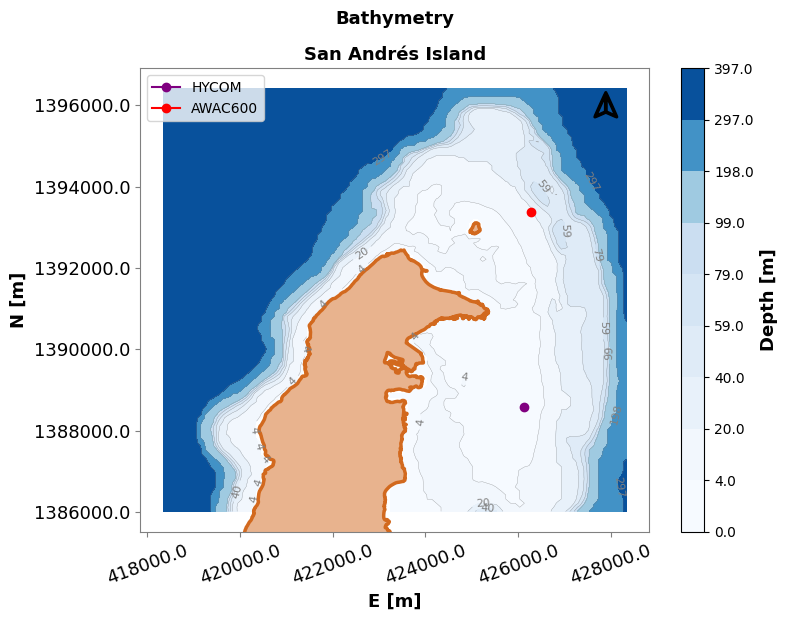

In [ ]:
path_bat = r"/content/drive/MyDrive/MODELO_NUMERICO/BATIMETRIA/BAT_NORTE_RECTANGULAR_100m"
# path = r'G:\My Drive\TESIS_MAESTRIA_PAULAE\MODELO_NUMERICO\BATIMETRIA\BAT_NORTE_RECTANGULAR_100m'
# path = r'C:\Users\paula\Desktop\BAT_SAI_NORTE_3D_V2'
name_file_grid = 'BAT_SAI_NORTE.grd'
name_file_deep = 'BAT_SAI_NORTE.dep'
name_file_coast = 'COAST_LINE.mat'

# num_lineas = 31
# n_rows = 238 #83
# n_cols = 155

num_lineas = 21
n_rows = 106 #83
n_cols = 102

df_lc = read_coast_line (path= path_bat, name_file = name_file_coast)
X, Y, Z = read_grid_file_d3d(num_btw_lines = num_lineas, ncols = n_cols, 
                             nrows = n_rows, path = path_bat, name_file_grid = name_file_grid, name_file_deep = name_file_deep)
df_bat_sai = df_project_grid_grid(n_cols = n_cols, n_rows = n_rows, X= X, Y = Y)
bat_figure(df_lc= df_lc,X= X, Y= Y, Z=Z[:-1,:-1], delta_lim= 500,delta = 450 ,size = (8, 6), active_puntos_obs = False)

#Ubicamos el punto de Hycom y del AWAC600
HYCOM=[-81.679993, 12.560000]
HYCOM_xy=proj_ZONE17(HYCOM[0],HYCOM[1])
AWAC600=[-81.678766, 12.603483]
AWAC600_xy=proj_ZONE17(AWAC600[0],AWAC600[1])
plt.plot(HYCOM_xy[0],HYCOM_xy[1], marker='o', color='purple',label='HYCOM')
plt.plot(AWAC600_xy[0],AWAC600_xy[1], marker='o', color='red', label='AWAC600')
plt.legend()

# Promedio mensual multianual por horas


In [ ]:
monthsname=calendar.month_name[1:]
#Se desea crear un diccionario cronograma promedio horario-diario-mensual-multianual
dic_cronovars={}
for ivar in ['water_temp','salinity']:
  dic_cronoprom={}
  for ilon in data_set.lon.values:
    for ilat in data_set.lat.values:
      #print('Punto : ',ilon,ilat)
      #Iteraremos entre todos los meses y haremos groupby por horas, guardamos en una lista cada mes, y añadimos dimension que indique el mes
      data_punto=data_set[ivar].sel(lat=ilat,lon=ilon,method='nearest').where(data_set.depth<=400,drop=True) #Modificar la variable segun necesite
      dic_month={}
      for imonth in range(1,13):
        dic_day={}
        for iday in np.unique(data_set.where(data_set.time.dt.month==imonth,drop=True).time.dt.day.values):
          dic_hour={}
          for ihour in np.unique(data_set.where((data_set.time.dt.month==imonth)&(data_set.time.dt.day==iday),drop=True).time.dt.hour.values):
            #print(i,day)
            #cronoprom_list.append(data_set.where((data_set.time.dt.month==i)&(data_set.time.dt.day==iday),drop=True).groupby('time.hour').mean().expand_dims(dim={'month':[i],'day':[iday]}))
            #print('Leyendo perfil')
            perfil=list(data_punto.where((data_punto.time.dt.month==imonth)&(data_punto.time.dt.day==iday)&(data_punto.time.dt.hour==ihour),drop=True).mean('time').values)
            #print(ihour,'Hora actualizada')
            dic_hour.update({int(ihour):perfil})
          #print(iday,'Dia Actualizado ----------------------------------------------------------------------------------------------------')
          dic_day.update({int(iday):dic_hour})
        #print(imonth,'Mes actualizado.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.-.')
        dic_month.update({monthsname[imonth-1]:dic_day})
      #print('Punto actualizado>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>')
      dic_cronoprom.update({str(ilon)+'_'+str(ilat):dic_month})
  dic_cronovars.update({ivar:dic_cronoprom})
#juntamos en un unico dataset
#ds_cronoprom=xr.merge(cronoprom_list)
#namefile='/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Scripts/Hourly_Sprofiles.json' #modificar la leta T o S segun la variable
#with open(namefile, "w") as namefile:
#    json.dump(dic_cronoprom, namefile)

In [ ]:
mesesDicAbr = {
    "01":'Ene',
    "02":'Feb',
    "03":'Mar',
    "04":'Abr',
    "05":'May',
    "06":'Jun',
    "07":'Jul',
    "08":'Ago',
    "09":'Sep',
    "10":'Oct',
    "11":'Nov',
    "12":'Dic'
}

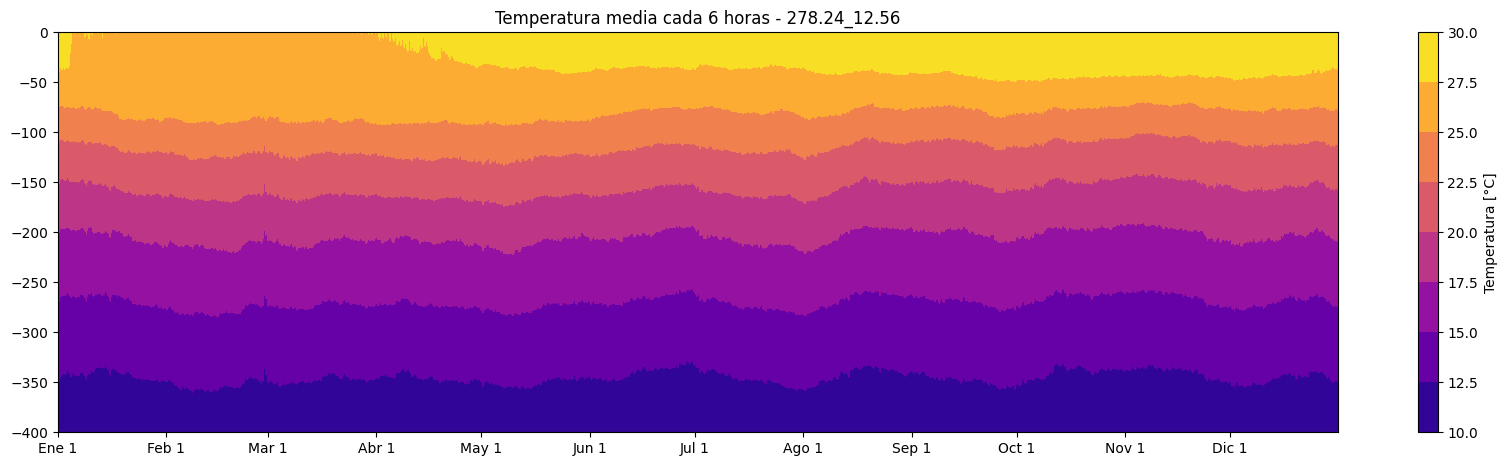

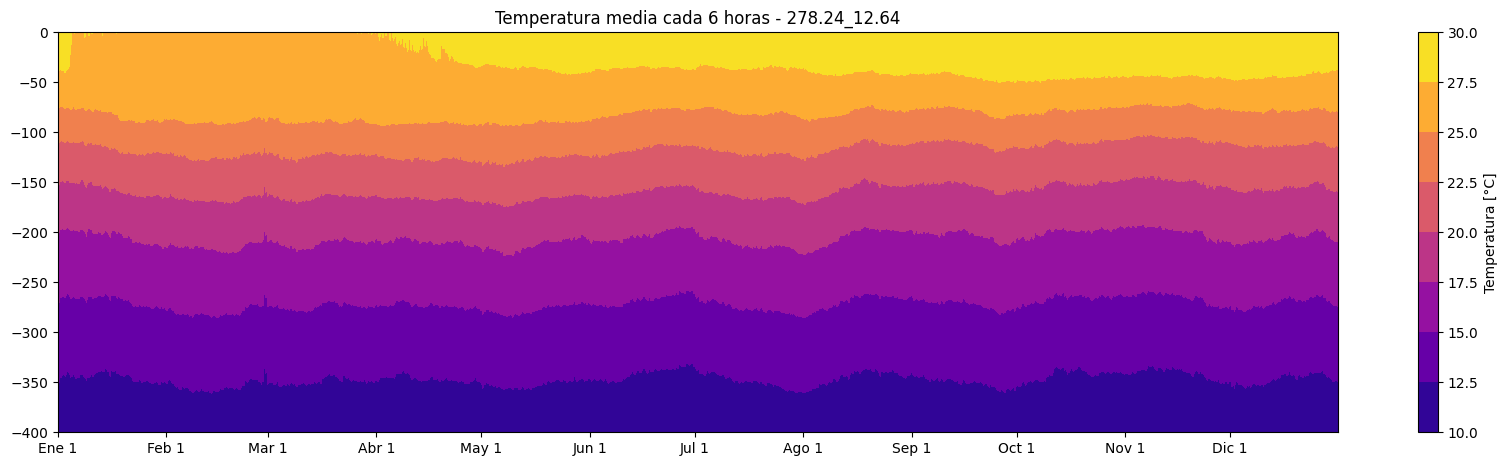

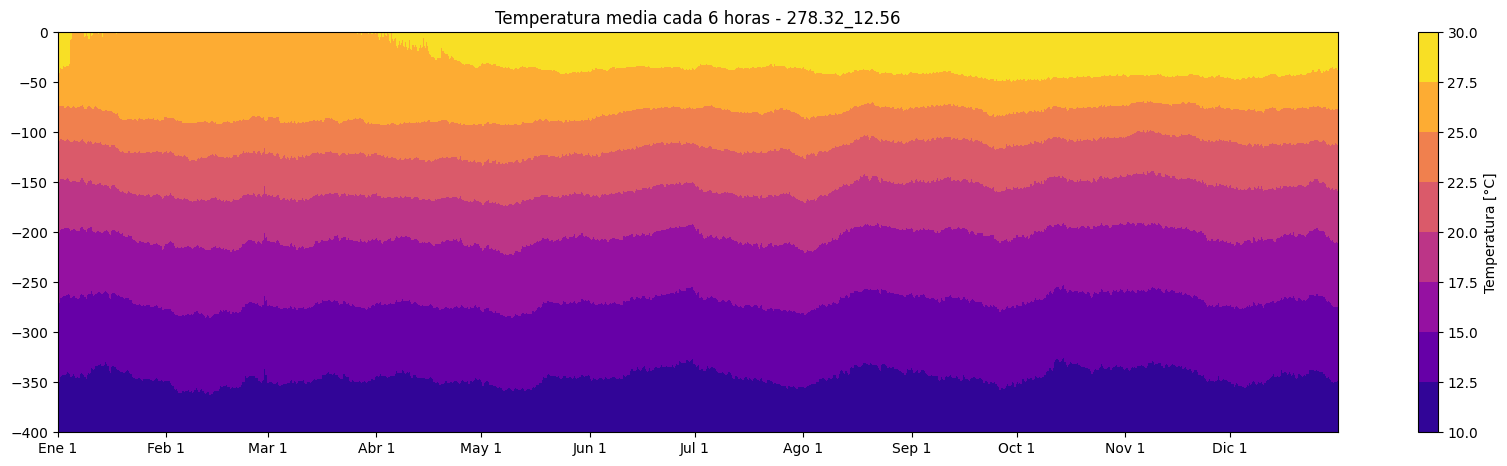

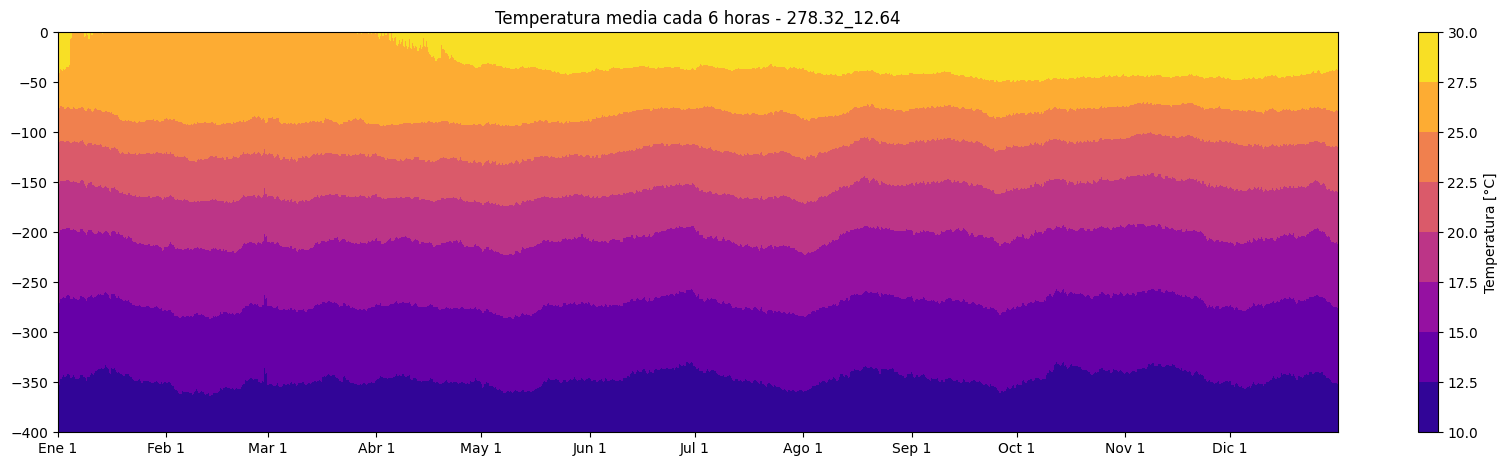

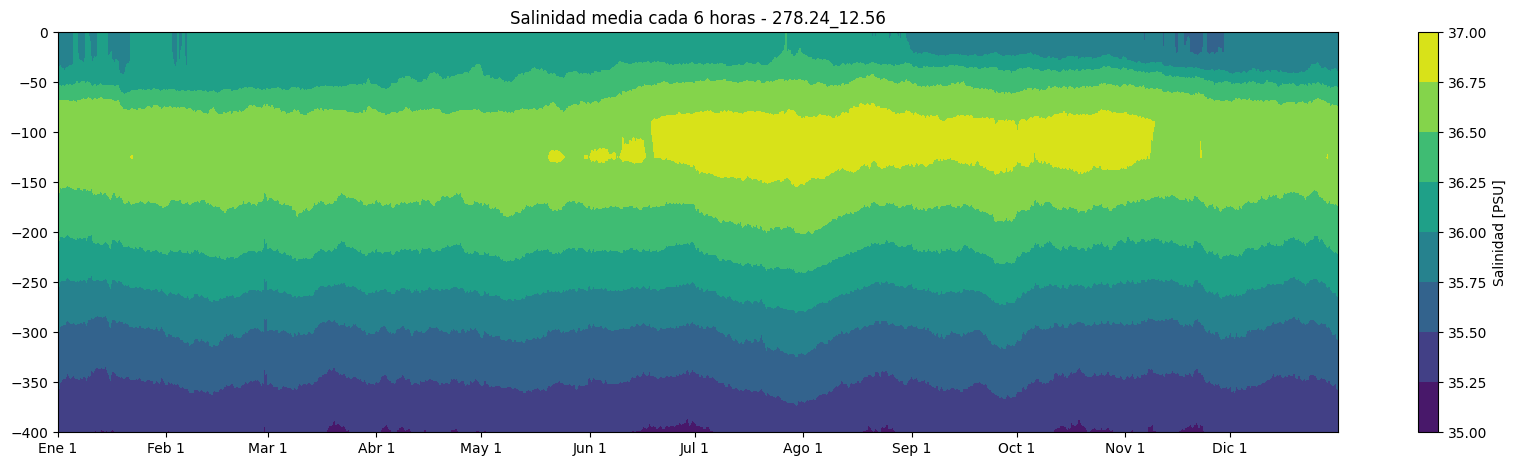

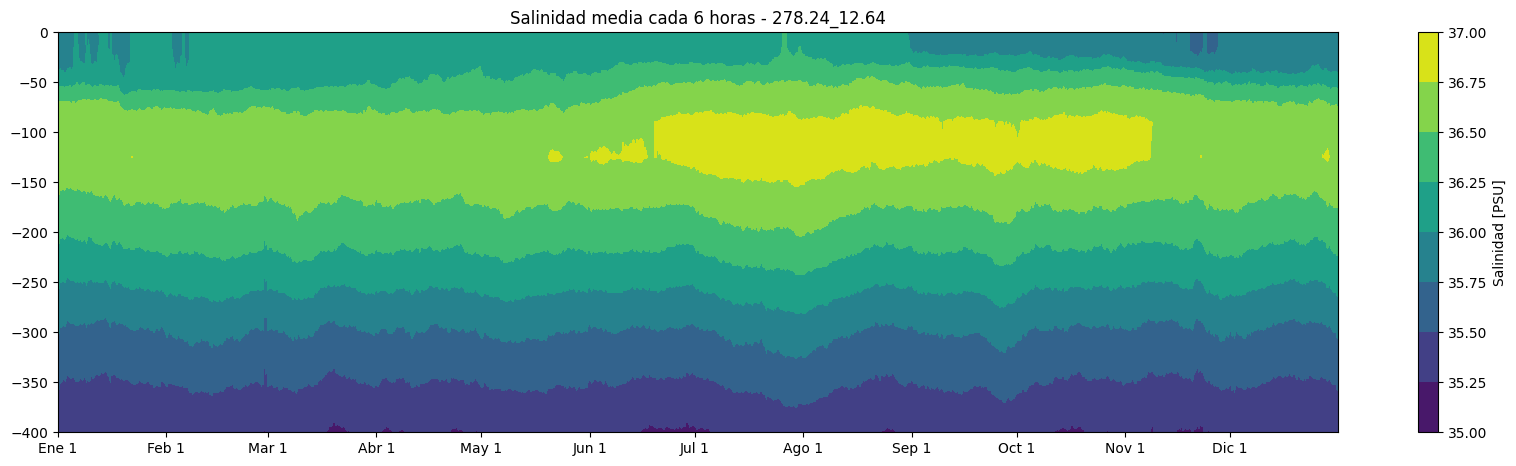

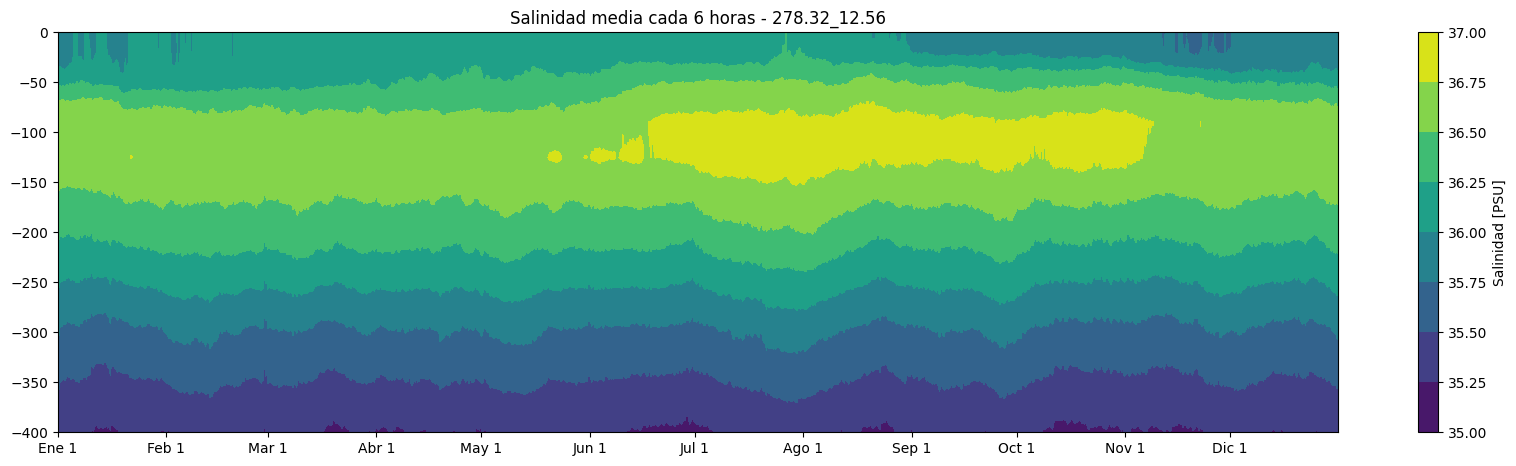

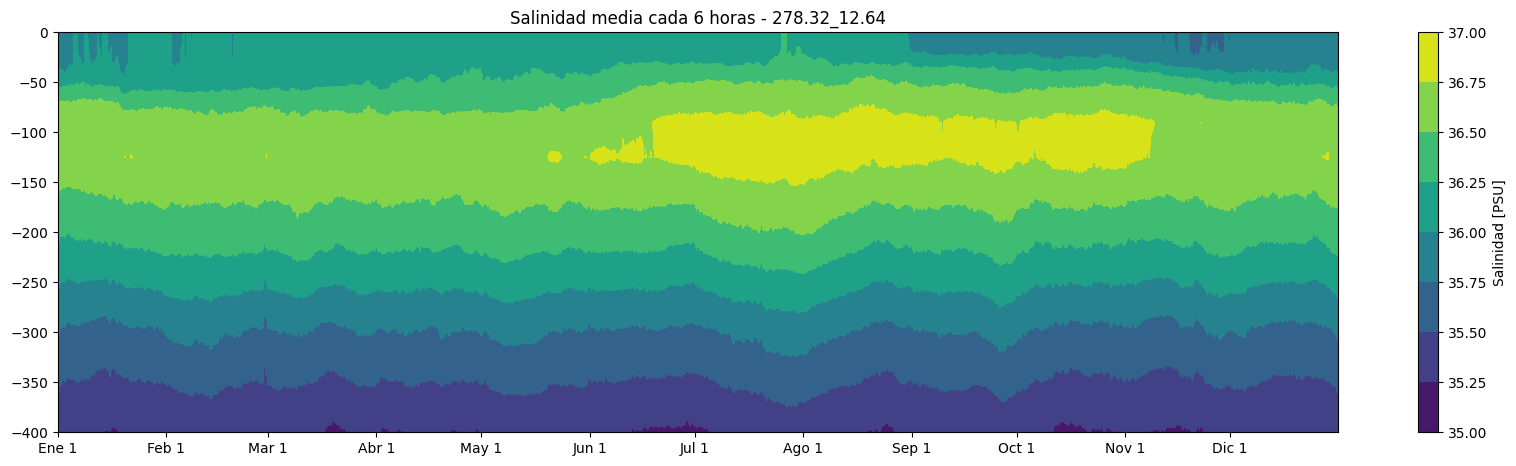

In [ ]:
#GRAFICO CONTOUR
#Matrices_hourly={}
for ivar in ['water_temp','salinity']:
  for ipoint in list(dic_cronovars[ivar].keys()):
    Matriz=[]
    Timeaxe=[]
    Months_Loc=[0]
    imonth_start=0
    monthdic_index=0
    for imonth in list(dic_cronovars[ivar][ipoint].keys()):
      for iday in list(dic_cronovars[ivar][ipoint][imonth].keys()):
        for ihour in list(dic_cronovars[ivar][ipoint][imonth][iday].keys()):
          Matriz.append(dic_cronovars[ivar][ipoint][imonth][iday][ihour])
          Timeaxe.append(list(mesesDicAbr.values())[monthdic_index]+' '+str(iday))
          imonth_start+=1
      Months_Loc.append(imonth_start)
      monthdic_index+=1
    plt.figure(figsize=(16,4))
    
    if ivar=='water_temp':
      plt.contourf(range(len(Timeaxe)),-data_set.where(data_set.depth<=400,drop=True).depth.values,np.array(Matriz).transpose(),cmap='plasma')
    else:
      plt.contourf(range(len(Timeaxe)),-data_set.where(data_set.depth<=400,drop=True).depth.values,np.array(Matriz).transpose())
    plt.ylim(bottom=-400)
    #plt.grid()
    plt.xticks(Months_Loc[:-1],[Timeaxe[i] for i in Months_Loc[:-1]])
    plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
    if ivar=='water_temp':
      plt.title('Temperatura media cada 6 horas - '+ipoint)
      plt.colorbar(label='Temperatura [°C]')
    else:
      plt.title('Salinidad media cada 6 horas - '+ipoint)
      plt.colorbar(label='Salinidad [PSU]')
    
    plt.show()


# Analisis de perfiles extremos (percentil 90) v2


Temperatura

In [ ]:
monthsname=calendar.month_name[1:]
print(monthsname)

['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']


In [ ]:
#Se hallara un perfil de temperatura representativo para el p90 en base a la Tmedia(en la profundidad)
#p90_Tall=[]#Lista que guardara los ds de cada punto en el espacio

#dic_Sdata={}
dic_Tdata={}
k=0
#Se iterara entre puentos en el espacio
for ilon in data_set.lon.values:
  for ilat in data_set.lat.values:
    #print(ilon,ilat)
    #p90_Tpermonth=[]#Lista que guardara el perfil para el punto
    p90_Tpermonth={}
    #Selecciona datos de T del punto
    data_T=data_set.water_temp.sel(lat=ilat,lon=ilon,method='nearest').where(data_set.depth<=400,drop=True) #modificar la variable segun se necesite
    #Se itera en los meses
    for i in range(1,13 ):
      #print(i)
      #Se extrae la informacion del mes
      data_T2=data_T.where(data_T.time.dt.month==i,drop=True)
      #se determina el limite p90 del mes
      p90_lim=data_T2.mean('depth').quantile(0.95,dim='time').values
      #Se extraen los perfiles del mes que cumplen que su Tmedia (en profundidad) sea >= al p90
      p90_perfil=data_T2.where(data_T2.mean('depth')>=p90_lim,drop=True)
      #Se promedia en el tiempo entre todos los perfiles que cumplieron la condicion
      #y se añade la dimension 'mes' para no perder su indicador y se reasigna lat y lon como dimensiones
      #p90_Tpermonth.append(p90_perfil.mean('time').expand_dims(dim={'month':[i],'lat':[ilat],'lon':[ilon]}))
      perfil=list(p90_perfil.mean('time').expand_dims(dim={'month':[i],'lat':[ilat],'lon':[ilon]}).values[0][0][0])
      p90_Tpermonth.update({monthsname[i-1]:perfil})
    #se combinan los meses en un unico data set para el punto
    k+=1
    #p90_Tpermonth=xr.merge(p90_Tpermonth)
    dic_Tdata.update({str(ilon)+'_'+str(ilat):p90_Tpermonth})
    #Se agrega a la lista de todos los puntos
    #p90_Tall.append(p90_Tpermonth)
#Se juntan todos los puntos en un unico ds
#p90_Tall=xr.merge(p90_Tall)
#dic_data=p90_Tall.to_dict()

In [ ]:

#namefile='/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Scripts/Extreme_Monthly_Sprofiles.json' #Modificar el indice T o S segun se necesite
#with open(namefile, "w") as namefile:
#    json.dump(dic_data, namefile)


In [ ]:
#GRAFICA DE CONTORNO DE PERFILES P95 
Matrices_Tp95=[]
for ipoint in dic_Tdata.keys():
  Matriz_p95=[]
  #print(dic_Sdata[ipoint])
  for imonth in dic_Tdata[ipoint].keys():
    Matriz_p95.append(dic_Tdata[ipoint][imonth])
    #print(dic_Sdata[ipoint][imonth])
  Matrices_Tp95.append(Matriz_p95)

In [ ]:
mesesDicAbr = {
    "01":'Ene',
    "02":'Feb',
    "03":'Mar',
    "04":'Abr',
    "05":'May',
    "06":'Jun',
    "07":'Jul',
    "08":'Ago',
    "09":'Sep',
    "10":'Oct',
    "11":'Nov',
    "12":'Dic'
}

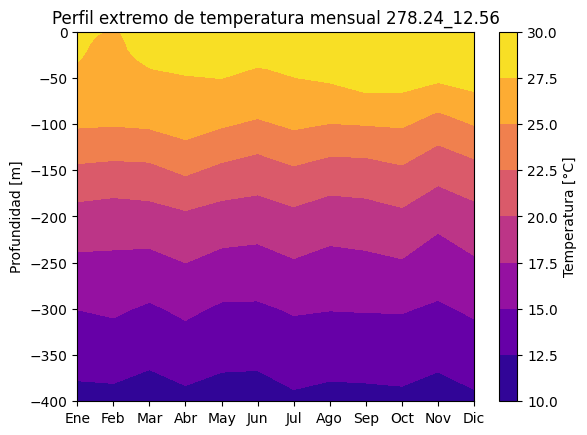

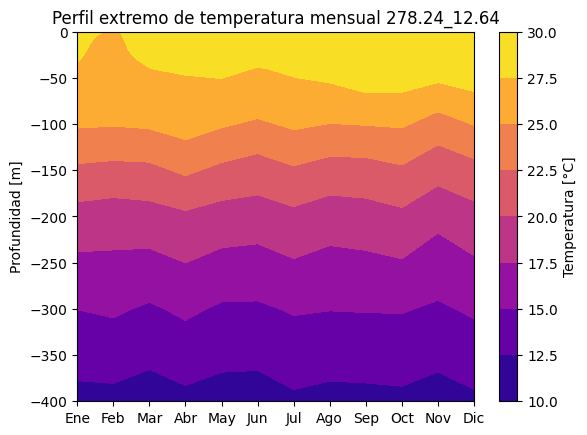

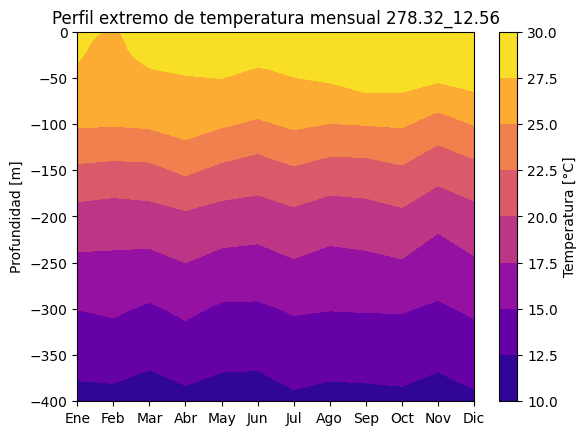

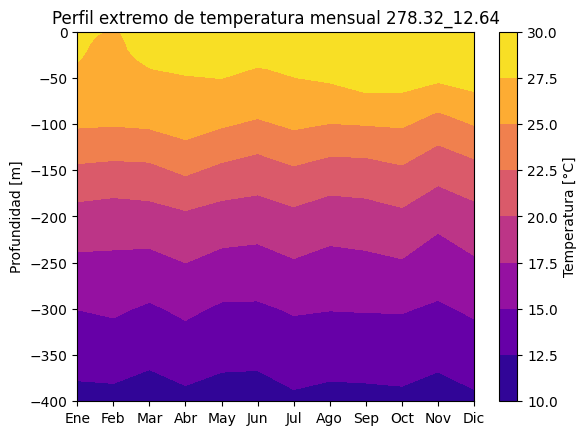

In [ ]:

for ipoint in dic_Tdata.keys():
  plt.contourf(mesesDicAbr.values(),-data_set.depth.values[:14],np.array(Matrices_Tp95[0]).transpose(),cmap='plasma')
  plt.ylim(top=0,bottom=-400)
  plt.title('Perfil extremo de temperatura mensual '+ipoint)
  plt.ylabel('Profundidad [m]')
  plt.colorbar(label='Temperatura [°C]')
  plt.show()

Salinidad

In [ ]:
#Se hallara un perfil de salinidad representativo para el p90 en base a la Tmedia(en la profundidad)
#p90_Tall=[]#Lista que guardara los ds de cada punto en el espacio

dic_Sdata={}
k=0
#Se iterara entre puentos en el espacio
for ilon in data_set.lon.values:
  for ilat in data_set.lat.values:
    #print(ilon,ilat)
    #p90_Tpermonth=[]#Lista que guardara el perfil para el punto
    p90_permonth={}
    #Selecciona datos de T del punto
    data=data_set.salinity.sel(lat=ilat,lon=ilon,method='nearest').where(data_set.depth<=200,drop=True) #modificar la variable segun se necesite
    #Se itera en los meses
    for i in range(1,13 ):
      #print(i)
      #Se extrae la informacion del mes
      data_2=data.where(data.time.dt.month==i,drop=True)
      #se determina el limite p90 del mes
      p90_lim=data_2.mean('depth').quantile(0.95,dim='time').values
      #Se extraen los perfiles del mes que cumplen que su Tmedia (en profundidad) sea >= al p90
      p90_perfil=data_2.where(data_2.mean('depth')>=p90_lim,drop=True)
      #Se promedia en el tiempo entre todos los perfiles que cumplieron la condicion
      #y se añade la dimension 'mes' para no perder su indicador y se reasigna lat y lon como dimensiones
      perfil=list(p90_perfil.mean('time').expand_dims(dim={'month':[i],'lat':[ilat],'lon':[ilon]}).values[0][0][0])
      p90_permonth.update({monthsname[i-1]:perfil})
    k+=1
    dic_Sdata.update({str(ilon)+'_'+str(ilat):p90_Tpermonth})
    

#namefile='/content/drive/MyDrive/CLIMATOLOGIA_HYCOM/Scripts/Extreme_Monthly_Sprofiles.json' #Modificar el indice T o S segun se necesite
#with open(namefile, "w") as namefile:
#    json.dump(dic_data, namefile)

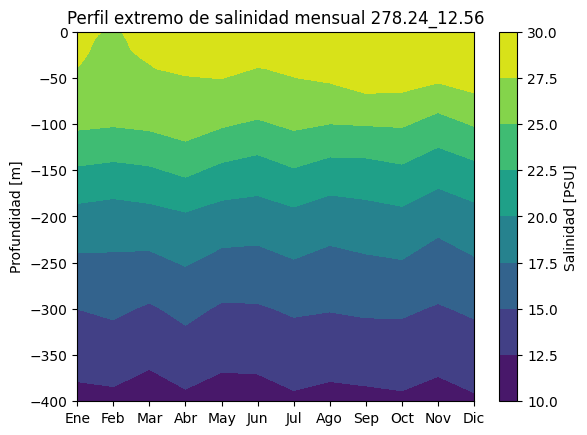

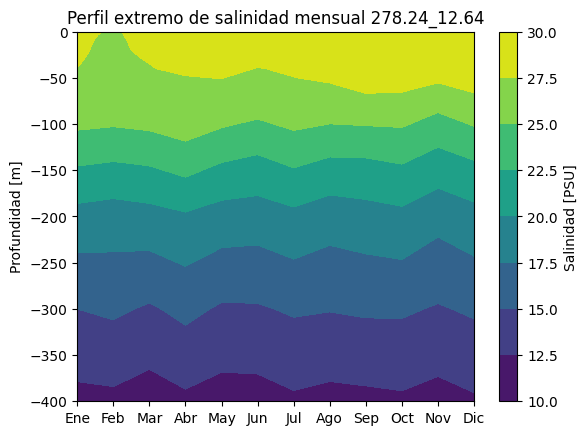

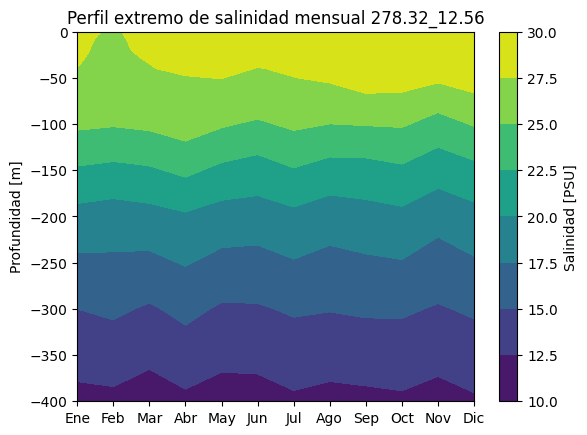

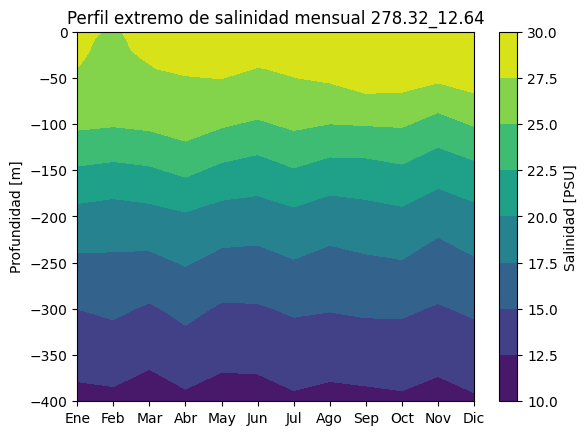

In [ ]:
#GRAFICA DE CONTORNO DE PERFILES P95 
Matrices_p95=[]
for ipoint in dic_Sdata.keys():
  Matriz_p95=[]
  #print(dic_Sdata[ipoint])
  for imonth in dic_Sdata[ipoint].keys():
    Matriz_p95.append(dic_Sdata[ipoint][imonth])
    #print(dic_Sdata[ipoint][imonth])
  Matrices_p95.append(Matriz_p95)

for ipoint in dic_Sdata.keys():
  plt.contourf(mesesDicAbr.values(),-data_set.depth.values[:14],np.array(Matrices_p95[0]).transpose())
  plt.ylim(top=0,bottom=-400)
  plt.title('Perfil extremo de salinidad mensual '+ipoint)
  plt.ylabel('Profundidad [m]')
  plt.colorbar(label='Salinidad [PSU]')
  plt.show()

Tecnica anterior

In [ ]:
# #Se hallara un perfil de salinidad representativo para el p90 en base a la Smedia(en la profundidad)
# p90_Sall=[]#Lista que guardara los ds de cada punto en el espacio
# #Se iterara entre puentos en el espacio
# for ilon in data_set.lon.values:
#   for ilat in data_set.lat.values:
#     print(ilon,ilat)
#     p90_Spermonth=[]#Lista que guardara el perfil para el punto
#     #Selecciona datos de S del punto
#     data_S=data_set.salinity.sel(lat=ilat,lon=ilon,method='nearest')
#     #Se itera en los meses
#     for i in range(1,13):
#       #print(i)
#       #Se extrae la informacion del mes
#       data_S2=data_S.where(data_S.time.dt.month==i,drop=True)
#       #se determina el limite p90 del mes
#       p90_lim=data_S2.mean('depth').quantile(0.95,dim='time').values
#       #Se extraen los perfiles del mes que cumplen que su Tmedia (en profundidad) sea >= al p90
#       p90_perfil=data_S2.where(data_S2.mean('depth')>=p90_lim,drop=True)
#       #Se promedia en el tiempo entre todos los perfiles que cumplieron la condicion
#       #y se añade la dimension 'mes' para no perder su indicador y se reasigna lat y lon como dimensiones
#       p90_Spermonth.append(p90_perfil.mean('time').expand_dims(dim={'month':[i],'lat':[ilat],'lon':[ilon]}))
#     #se combinan los meses en un unico data set para el punto
#     p90_Spermonth=xr.merge(p90_Spermonth)
#     #Se agrega a la lista de todos los puntos
#     p90_Sall.append(p90_Spermonth)
# #Se juntan todos los puntos en un unico ds
# p90_Sall=xr.merge(p90_Sall)
# p90_Sall#.to_dict()

Grafico de p95 con limites de p90 y p99

In [ ]:
#Determinar los perfiles para cuantiles 90 95 y 99

quantile_limits={}
for ivar in ['water_temp','salinity']:
  dic_plim={}
  for iplim in [0.9,0.95,0.99]:
    dic_data={}
    k=0
    #Se iterara entre puentos en el espacio
    for ilon in data_set.lon.values:
      for ilat in data_set.lat.values:
        #print(ilon,ilat)
        #p90_Tpermonth=[]#Lista que guardara el perfil para el punto
        p90_permonth={}
        #Selecciona datos de T del punto
        data=data_set[ivar].sel(lat=ilat,lon=ilon,method='nearest').where(data_set.depth<=400,drop=True) #modificar la variable segun se necesite
        #print(data)
        #Se itera en los meses
        for i in range(1,13 ):
          #print(i)
          #Se extrae la informacion del mes
          data_2=data.where(data.time.dt.month==i,drop=True)
          #se determina el limite p90 del mes
          p90_lim=data_2.mean('depth').quantile(iplim,dim='time').values
          #Se extraen los perfiles del mes que cumplen que su Tmedia (en profundidad) sea >= al p90
          p90_perfil=data_2.where(data_2.mean('depth')>=p90_lim,drop=True)
          #print(p90_perfil)
          #Se promedia en el tiempo entre todos los perfiles que cumplieron la condicion
          #y se añade la dimension 'mes' para no perder su indicador y se reasigna lat y lon como dimensiones
          perfil=list(p90_perfil.mean('time').expand_dims(dim={'month':[i],'lat':[ilat],'lon':[ilon]}).values[0][0][0])
          p90_permonth.update({monthsname[i-1]:perfil})
        k+=1
        dic_data.update({str(ilon)+'_'+str(ilat):p90_permonth})
      dic_plim.update({iplim:dic_data})
    quantile_limits.update({ivar:dic_plim})

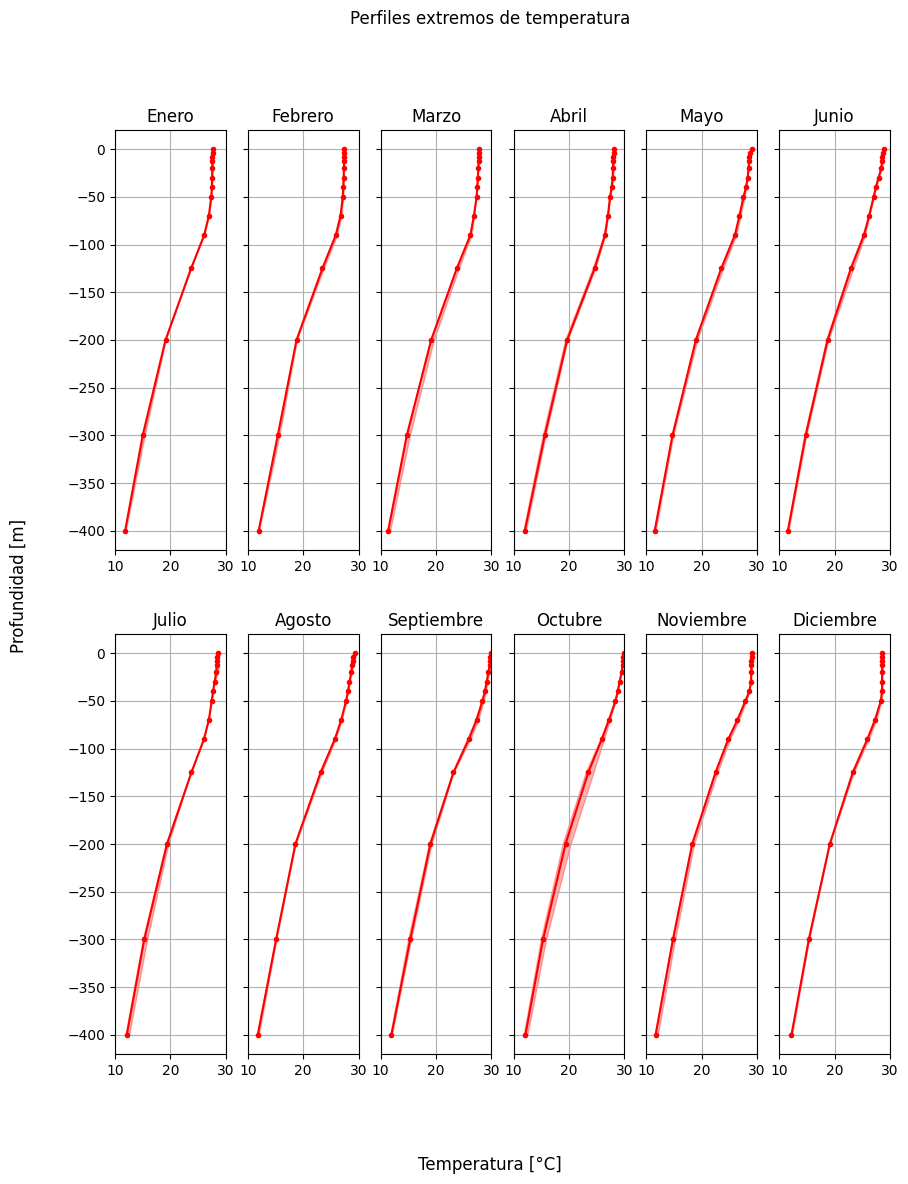

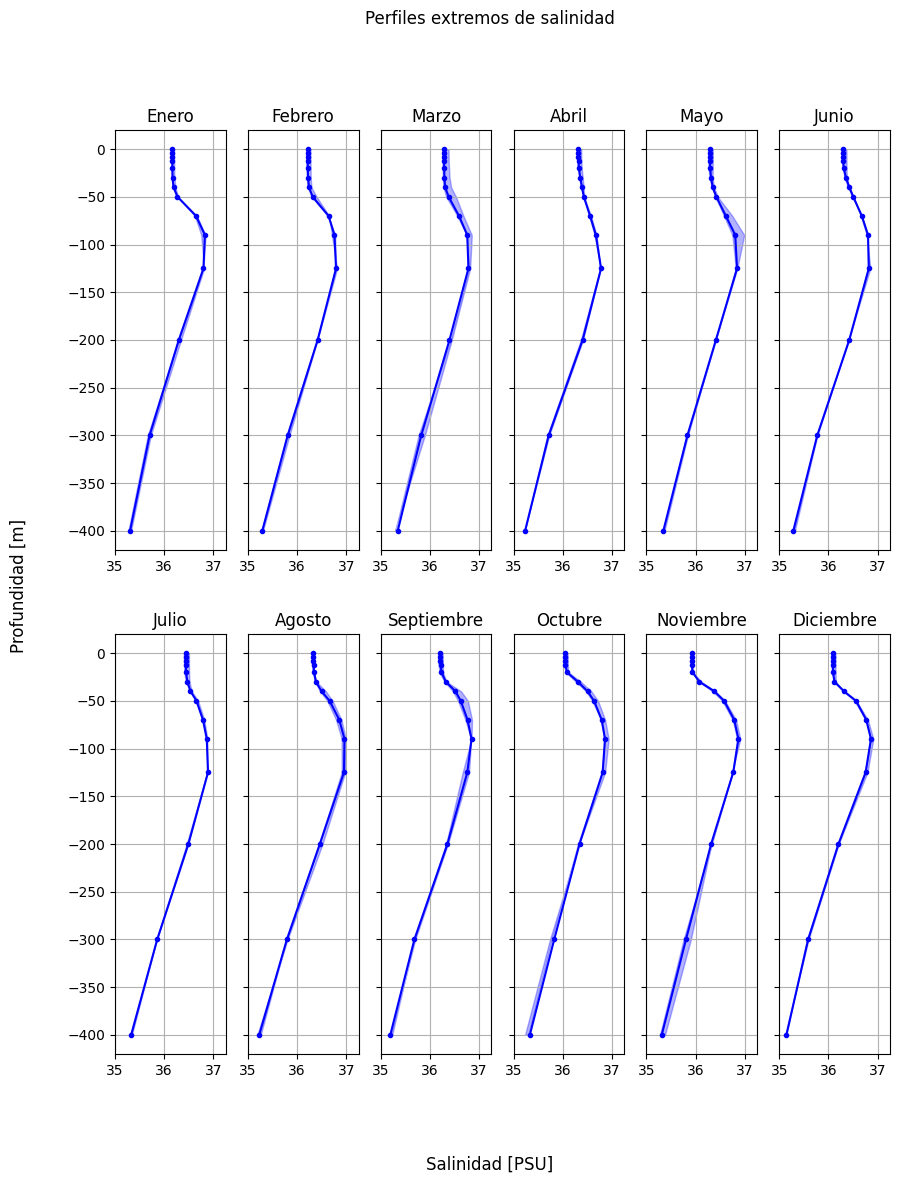

In [ ]:
mesesDic = {
    "01":'Enero',
    "02":'Febrero',
    "03":'Marzo',
    "04":'Abril',
    "05":'Mayo',
    "06":'Junio',
    "07":'Julio',
    "08":'Agosto',
    "09":'Septiembre',
    "10":'Octubre',
    "11":'Noviembre',
    "12":'Diciembre'
}
months_keys=list(quantile_limits['water_temp'][0.9]['278.32_12.64'].keys())
for ivar in list(quantile_limits.keys()):
  #print(ivar)
  fig,axs = plt.subplots(2,6,sharey=True,figsize=(10,12))
  k=1
  for irow in range(2):
    for icol in range(6):
      #print(irow,icol,k)
      
      if ivar=='water_temp':
        axs[irow][icol].plot(quantile_limits[ivar][0.95]['278.32_12.64'][months_keys[k-1]],-data_set.where(data_set.depth<=400,drop=True).depth.values,marker='.',color='red')
        axs[irow][icol].fill_betweenx(-data_set.where(data_set.depth<=400,drop=True).depth.values,
                                      quantile_limits[ivar][0.90]['278.32_12.64'][months_keys[k-1]],
                                    quantile_limits[ivar][0.99]['278.32_12.64'][months_keys[k-1]],
                                    alpha=0.3, color='red')
        axs[irow][icol].grid(), axs[irow][icol].set_title(list(mesesDic.values())[k-1])
        axs[irow][icol].set_xlim(right=30,left=10)
      else:
        axs[irow][icol].plot(quantile_limits[ivar][0.95]['278.32_12.64'][months_keys[k-1]],-data_set.where(data_set.depth<=400,drop=True).depth.values,marker='.',color='blue')
        axs[irow][icol].fill_betweenx(-data_set.where(data_set.depth<=400,drop=True).depth.values,
                                      quantile_limits[ivar][0.90]['278.32_12.64'][months_keys[k-1]],
                                    quantile_limits[ivar][0.99]['278.32_12.64'][months_keys[k-1]],
                                    alpha=0.3, color='blue')
        axs[irow][icol].grid(), axs[irow][icol].set_title(list(mesesDic.values())[k-1])
        axs[irow][icol].set_xlim(right=37.25,left=35)
      k+=1
  fig.supylabel('Profundidad [m]')
  if ivar=='water_temp':
    fig.supxlabel('Temperatura [°C]')
    fig.suptitle('Perfiles extremos de temperatura')
  else:
    fig.supxlabel('Salinidad [PSU]')
    fig.suptitle('Perfiles extremos de salinidad')
  
  #plt.show()


* calcular el p90 y p99 para grafico de limites del punto NE